**Dev note**: Parts of this notebook have been adapted to coffea v2024. However, the executor/runner section needs to be migrated to using `apply_to_fileset` and potentially `preprocess`, and the way the fileset is defined will also need to be changed.

# CMS Open Data $t\bar{t}$: from data delivery to statistical inference

We are using [2015 CMS Open Data](https://cms.cern/news/first-cms-open-data-lhc-run-2-released) in this demonstration to showcase an analysis pipeline.
It features data delivery and processing, histogram construction and visualization, as well as statistical inference.

This notebook was developed in the context of the [IRIS-HEP AGC tools 2022 workshop](https://indico.cern.ch/e/agc-tools-2).
This work was supported by the U.S. National Science Foundation (NSF) Cooperative Agreement OAC-1836650 (IRIS-HEP).

This is a **technical demonstration**.
We are including the relevant workflow aspects that physicists need in their work, but we are not focusing on making every piece of the demonstration physically meaningful.
This concerns in particular systematic uncertainties: we capture the workflow, but the actual implementations are more complex in practice.
If you are interested in the physics side of analyzing top pair production, check out the latest results from [ATLAS](https://twiki.cern.ch/twiki/bin/view/AtlasPublic/TopPublicResults) and [CMS](https://cms-results.web.cern.ch/cms-results/public-results/preliminary-results/)!
If you would like to see more technical demonstrations, also check out an [ATLAS Open Data example](https://indico.cern.ch/event/1076231/contributions/4560405/) demonstrated previously.

This notebook implements most of the analysis pipeline shown in the following picture, using the tools also mentioned there:
![ecosystem visualization](utils/ecosystem.png)

### Data pipelines

There are two possible pipelines: one with `ServiceX` enabled, and one using only `coffea` for processing.
![processing pipelines](utils/processing_pipelines.png)

### Imports: setting up our environment

In [1]:
import logging
import time

import awkward as ak
import cabinetry
import cloudpickle
import correctionlib
from coffea import processor
from coffea.analysis_tools import PackedSelection
from coffea.dataset_tools import preprocess,apply_to_fileset, max_files, max_chunks
from coffea.dataset_tools.dataset_query import DataDiscoveryCLI
import copy
import dask
from dask_jobqueue import HTCondorCluster
from dask.distributed import Client, performance_report
import datetime
import gzip
import hist
import hist.dask as hda
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle as pkl
import pyhf

import utils  # contains code for bookkeeping and cosmetics, as well as some boilerplate

logging.getLogger("cabinetry").setLevel(logging.INFO)

### Configuration: number of files and data delivery path

The number of files per sample set here determines the size of the dataset we are processing. There are 9 samples being used here, all part of the 2015 CMS Open Data release.

These samples were originally published in miniAOD format, but for the purposes of this demonstration were pre-converted into nanoAOD format. More details about the inputs can be found [here](https://github.com/iris-hep/analysis-grand-challenge/tree/main/datasets/cms-open-data-2015).

The table below summarizes the amount of data processed depending on the `N_FILES_MAX_PER_SAMPLE` setting.

| setting | number of files | total size | number of events |
| --- | --- | --- | --- |
| `1` | 9 | 22.9 GB | 10,455,719 |
| `2` | 18 | 42.8 GB | 19,497,435 |
| `5` | 43 | 105 GB | 47,996,231 |
| `10` | 79 | 200 GB | 90,546,458 |
| `20` | 140 | 359 GB | 163,123,242 |
| `50` | 255 | 631 GB | 297,247,463 |
| `100` | 395 | 960 GB | 470,397,795 |
| `200` | 595 | 1.40 TB | 705,273,291 |
| `-1` | 787 | 1.78 TB | 940,160,174 |

The input files are all in the 1–3 GB range.

In [2]:
### GLOBAL CONFIGURATION
# input files per process, set to e.g. 10 (smaller number = faster)
N_FILES_MAX_PER_SAMPLE = 5 #If None, there is no max
N_CHUNKS_MAX_PER_FILE = None #If None, there is no max
# number of seconds before giving up on file reading
TIMEOUT = 300

# number of distributed workers to request
MAX_WORKERS = 250

# enable Dask
USE_DASK = True

# enable ServiceX
USE_SERVICEX = False

### ML-INFERENCE SETTINGS

# enable ML inference
USE_INFERENCE = False

# enable inference using NVIDIA Triton server
USE_TRITON = False

### Defining our `coffea` Processor

The processor includes a lot of the physics analysis details:
- event filtering and the calculation of observables,
- event weighting,
- calculating systematic uncertainties at the event and object level,
- filling all the information into histograms that get aggregated and ultimately returned to us by `coffea`.

#### Machine Learning Task

During the processing step, machine learning is used to calculate one of the variables used for this analysis. The models used are trained separately in the `jetassignment_training.ipynb` notebook. Jets in the events are assigned to labels corresponding with their parent partons using a boosted decision tree (BDT). More information about the model and training can be found within that notebook.

In [3]:
class TtbarAnalysis(processor.ProcessorABC):
    def __init__(self, use_inference, use_triton):

        # NOTE: START VERSION MIGRATION REGION (VMR), which has been migrated
        # initialize dictionary of hists for signal and control region
        self.hist_dict = {}
        for region in ["4j1b", "4j2b"]:
            self.hist_dict[region] = (
                hda.Hist(hist.axis.Regular(utils.config["global"]["NUM_BINS"], 
                                  utils.config["global"]["BIN_LOW"], 
                                  utils.config["global"]["BIN_HIGH"], 
                                  name="observable", 
                                  label="observable [GeV]"),
                    hist.axis.StrCategory([], name="process", label="Process", growth=True),
                    hist.axis.StrCategory([], name="variation", label="Systematic variation", growth=True),
                    storage=hist.storage.Weight()
                )
            )
        
        self.cset = correctionlib.CorrectionSet.from_file("corrections.json")
        self.use_inference = use_inference

        # NOTE: END VMR
        # set up attributes only needed if USE_INFERENCE=True
        if self.use_inference:
            
            # initialize dictionary of hists for ML observables
            self.ml_hist_dict = {}
            for i in range(len(utils.config["ml"]["FEATURE_NAMES"])):
                self.ml_hist_dict[utils.config["ml"]["FEATURE_NAMES"][i]] = (
                    hist.Hist.new.Reg(utils.config["global"]["NUM_BINS"],
                                      utils.config["ml"]["BIN_LOW"][i],
                                      utils.config["ml"]["BIN_HIGH"][i],
                                      name="observable",
                                      label=utils.config["ml"]["FEATURE_DESCRIPTIONS"][i])
                    .StrCat([], name="process", label="Process", growth=True)
                    .StrCat([], name="variation", label="Systematic variation", growth=True)
                    .Weight()
                )
            
            self.use_triton = use_triton

    def only_do_IO(self, events):
        for branch in utils.config["benchmarking"]["IO_BRANCHES"][
            utils.config["benchmarking"]["IO_FILE_PERCENT"]
        ]:
            if "_" in branch:
                split = branch.split("_")
                object_type = split[0]
                property_name = "_".join(split[1:])
                ak.materialized(events[object_type][property_name])
            else:
                ak.materialized(events[branch])
        return {"hist": {}}

    def process(self, events):
        if utils.config["benchmarking"]["DISABLE_PROCESSING"]:
            # IO testing with no subsequent processing
            return self.only_do_IO(events)

        process = events.metadata["metadata"]["process"]  # "ttbar" etc.
        variation = events.metadata["metadata"]["variation"]  # "nominal" etc.

        # normalization for MC
        x_sec = events.metadata["metadata"]["xsec"]
        nevts_total = ak.num(events,axis=0)
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1

        # setup triton gRPC client
        if self.use_inference and self.use_triton:
            triton_client = utils.clients.get_triton_client(utils.config["ml"]["TRITON_URL"])


        #### systematics
        # jet energy scale / resolution systematics
        # need to adjust schema to instead use coffea add_systematic feature, especially for ServiceX
        # cannot attach pT variations to events.jet, so attach to events directly
        # and subsequently scale pT by these scale factors
        events["pt_scale_up"] = 1.03
        events["pt_res_up"] = utils.systematics.jet_pt_resolution(events.Jet.pt,events.Jet.phi)

        syst_variations = ["nominal"]
        jet_kinematic_systs = ["pt_scale_up", "pt_res_up"]
        event_systs = [f"btag_var_{i}" for i in range(4)]
        if process == "wjets":
            event_systs.append("scale_var")

        # Only do systematics for nominal samples, e.g. ttbar__nominal
        if variation == "nominal":
            syst_variations.extend(jet_kinematic_systs)
            syst_variations.extend(event_systs)

        # for pt_var in pt_variations:
        for syst_var in syst_variations:
            ### event selection
            # very very loosely based on https://arxiv.org/abs/2006.13076

            # Note: This creates new objects, distinct from those in the 'events' object
            elecs = events.Electron
            muons = events.Muon
            jets = events.Jet
            if syst_var in jet_kinematic_systs:
                # Replace jet.pt with the adjusted values
                jets["pt"] = jets.pt * events[syst_var]

            electron_reqs = (elecs.pt > 30) & (abs(elecs.eta) < 2.1) & (elecs.cutBased == 4) & (elecs.sip3d < 4)
            muon_reqs = ((muons.pt > 30) & (abs(muons.eta) < 2.1) & (muons.tightId) & (muons.sip3d < 4) &
                         (muons.pfRelIso04_all < 0.15))
            jet_reqs = (jets.pt > 30) & (abs(jets.eta) < 2.4) & (jets.isTightLeptonVeto)

            # Only keep objects that pass our requirements
            elecs = elecs[electron_reqs]
            muons = muons[muon_reqs]
            jets = jets[jet_reqs]

            if self.use_inference:
                even = (events.event%2==0)  # whether events are even/odd

            B_TAG_THRESHOLD = 0.5

            ######### Store boolean masks with PackedSelection ##########
            selections = PackedSelection(dtype='uint64')
            # Basic selection criteria
            selections.add("exactly_1l", (ak.num(elecs) + ak.num(muons)) == 1)
            selections.add("atleast_4j", ak.num(jets) >= 4)
            selections.add("exactly_1b", ak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) == 1)
            selections.add("atleast_2b", ak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2)
            # Complex selection criteria
            selections.add("4j1b", selections.all("exactly_1l", "atleast_4j", "exactly_1b"))
            selections.add("4j2b", selections.all("exactly_1l", "atleast_4j", "atleast_2b"))

            #for region in ["4j1b", "4j2b"]: #FIXME: DELETE LATER
            for region in ["4j2b"]:
                region_selection = selections.all(region)
                region_jets = jets[region_selection]
                region_elecs = elecs[region_selection]
                region_muons = muons[region_selection]
                region_weights = ak.ones_like(ak.num(region_jets)) * xsec_weight
                if self.use_inference:
                    region_even = even[region_selection]

                if region == "4j1b":
                    observable = ak.sum(region_jets.pt, axis=-1)

                elif region == "4j2b":

                    # reconstruct hadronic top as bjj system with largest pT
                    trijet = ak.combinations(region_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidates
                    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
                    trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
                    btag_filt = (trijet.j1.btagCSVV2 > B_TAG_THRESHOLD) | (trijet.j2.btagCSVV2 > B_TAG_THRESHOLD) | (trijet.j3.btagCSVV2 > B_TAG_THRESHOLD)
                    trijet = trijet[btag_filt]  # at least one-btag in trijet candidates
                    # pick trijet candidate with largest pT and calculate mass of system
                    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
                    observable = ak.flatten(trijet_mass)

                    if ak.sum(region_selection)==0:
                        continue

                    if self.use_inference:
                        features, perm_counts = utils.ml.get_features(
                            region_jets,
                            region_elecs,
                            region_muons,
                            max_n_jets=utils.config["ml"]["MAX_N_JETS"],
                        )
                        even_perm = np.repeat(region_even, perm_counts)

                        # calculate ml observable
                        if self.use_triton:
                            results = utils.ml.get_inference_results_triton(
                                features,
                                even_perm,
                                triton_client,
                                utils.config["ml"]["MODEL_NAME"],
                                utils.config["ml"]["MODEL_VERSION_EVEN"],
                                utils.config["ml"]["MODEL_VERSION_ODD"],
                            )

                        else:
                            results = utils.ml.get_inference_results_local(
                                features,
                                even_perm,
                                utils.ml.model_even,
                                utils.ml.model_odd,
                            )
                            
                        results = ak.unflatten(results, perm_counts)
                        features = ak.flatten(ak.unflatten(features, perm_counts)[
                            ak.from_regular(ak.argmax(results,axis=1)[:, np.newaxis])
                        ])
                syst_var_name = f"{syst_var}"
                # Break up the filling into event weight systematics and object variation systematics
                if syst_var in event_systs:
                    for i_dir, direction in enumerate(["up", "down"]):
                        # Should be an event weight systematic with an up/down variation
                        if syst_var.startswith("btag_var"):
                            i_jet = int(syst_var.rsplit("_",1)[-1])   # Kind of fragile
                            wgt_variation = self.cset["event_systematics"].evaluate("btag_var", direction, region_jets.pt[:,i_jet])
                        elif syst_var == "scale_var":
                            # The pt array is only used to make sure the output array has the correct shape
                            wgt_variation = self.cset["event_systematics"].evaluate("scale_var", direction, region_jets.pt[:,0])
                        syst_var_name = f"{syst_var}_{direction}"
                        self.hist_dict[region].fill(
                            observable=observable, process=process,
                            variation=syst_var_name, weight=region_weights * wgt_variation
                        )
                        if region == "4j2b" and self.use_inference:
                            for i in range(len(utils.config["ml"]["FEATURE_NAMES"])):
                                self.ml_hist_dict[utils.config["ml"]["FEATURE_NAMES"][i]].fill(
                                    observable=features[..., i], process=process,
                                    variation=syst_var_name, weight=region_weights * wgt_variation
                                )
                else:
                    # Should either be 'nominal' or an object variation systematic
                    if variation != "nominal":
                        # This is a 2-point systematic, e.g. ttbar__scaledown, ttbar__ME_var, etc.
                        syst_var_name = variation
                    self.hist_dict[region].fill(
                        observable=observable, process=process,
                        variation=syst_var_name, weight=region_weights
                    )
                    if region == "4j2b" and self.use_inference:
                        for i in range(len(utils.config["ml"]["FEATURE_NAMES"])):
                            self.ml_hist_dict[utils.config["ml"]["FEATURE_NAMES"][i]].fill(
                                observable=features[..., i], process=process,
                                variation=syst_var_name, weight=region_weights
                            )


        output = {"nevents": {events.metadata["dataset"]: ak.num(events,axis=0)}, "hist_dict": self.hist_dict}
        if self.use_inference:
            output["ml_hist_dict"] = self.ml_hist_dict

        return output

    def postprocess(self, accumulator):
        return accumulator

### "Fileset" construction and metadata

Here, we gather all the required information about the files we want to process: paths to the files and asociated metadata.

In [4]:
dataset_definition = {
    #ttbar_hadronic
    "/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODSIM": {
        "short_name": "ttbar",
        "metadata": {"process": "ttbar",
                     "variation": "nominal",
                     "xsec": 377.96}
    },
    #Single top s-channel
    "/ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM": {
        "short_name": "single_top_s_chan",
        "metadata": {"process": "single_top_s_chan",
                     "variation": "nominal",
                     "xsec": 7.104}
    },
    #Single top t-channel top
    "/ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM": {
        "short_name": "single_top_t_chan_top",
        "metadata": {"process": "single_top_t_chan_top",
                     "variation": "nominal",
                     "xsec": 113.3}
    },
    #Single top t-channel antitop
    "/ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM": {
        "short_name": "single_top_t_chan_antitop",
        "metadata": {"process": "single_top_t_chan_antitop",
                     "variation": "nominal",
                     "xsec": 67.91}
    },
    #Single top tW antitop
    "/ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2/NANOAODSIM": {
        "short_name": "single_top_tW_antitop",
        "metadata": {"process": "single_top_tW_antitop",
                     "variation": "normal",
                     "xsec": 32.51}
    },
    #Single top tW top
    "/ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2/NANOAODSIM": {
        "short_name": "single_top_tW_top",
        "metadata": {"process": "single_top_tW_top",
                     "variation": "normal",
                     "xsec": 32.45}
    },
    #WJets 1 jet
    "/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM": {
        "short_name": "wjets_1j",
        "metadata": {"process": "wjets_1j",
                     "variation": "normal",
                     "xsec": 8832.0}
    },
    #WJets 2 jets
    "/WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM": {
        "short_name": "wjets_2j",
        "metadata": {"process": "wjets_2j",
                     "variation": "normal",
                     "xsec": 3276.0}
    }
}

In [5]:
ddc = DataDiscoveryCLI()
ddc.load_dataset_definition(dataset_definition,
                                        query_results_strategy="all",
                                        replicas_strategy="round-robin");

Processing query: 
/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODS
IM

Output()

                                                      Query:                                                       
/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODS
                                                        IM                                                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳┓
┃ Name                                ┃ Tag                                                                      ┃┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇┩
│ TTToHadronic_TuneCP5_13TeV-powheg-… │ (1) RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NAN… ││
└─────────────────────────────────────┴──────────────────────────────────────────────────────────────────────────┴┘

Use the command select to selected the datasets

Selected datasets:

- (1) 
/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODS
IM

Processing query: 
/ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realisti
c_v16_L1v1-v1/NANOAODSIM

Output()

                                                      Query:                                                       
/ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realisti
                                             c_v16_L1v1-v1/NANOAODSIM                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳┓
┃ Name                                         ┃ Tag                                                             ┃┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇┩
│ ST_s-channel_4f_hadronicDecays_TuneCP5_13Te… │ (1) RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_… ││
└──────────────────────────────────────────────┴─────────────────────────────────────────────────────────────────┴┘

Use the command select to selected the datasets

Selected datasets:

- (1) 
/ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realisti
c_v16_L1v1-v1/NANOAODSIM

Processing query: 
/ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade20
18_realistic_v16_L1v1-v1/NANOAODSIM

Output()

                                                      Query:                                                       
/ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade20
                                        18_realistic_v16_L1v1-v1/NANOAODSIM                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳┓
┃ Name                                               ┃ Tag                                                       ┃┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇┩
│ ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV… │ (1) RunIISummer20UL18NanoAODv9-106X_upgrade2018_realisti… ││
└────────────────────────────────────────────────────┴───────────────────────────────────────────────────────────┴┘

Use the command select to selected the datasets

Selected datasets:

- (1) 
/ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade20
18_realistic_v16_L1v1-v1/NANOAODSIM

Processing query: 
/ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgra
de2018_realistic_v16_L1v1-v1/NANOAODSIM

Output()

                                                      Query:                                                       
/ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgra
                                      de2018_realistic_v16_L1v1-v1/NANOAODSIM                                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳┓
┃ Name                                                 ┃ Tag                                                     ┃┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇┩
│ ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13T… │ (1) RunIISummer20UL18NanoAODv9-106X_upgrade2018_realis… ││
└──────────────────────────────────────────────────────┴─────────────────────────────────────────────────────────┴┘

Use the command select to selected the datasets

Selected datasets:

- (1) 
/ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgra
de2018_realistic_v16_L1v1-v1/NANOAODSIM

Processing query: 
/ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realisti
c_v16_L1v1-v2/NANOAODSIM

Output()

                                                      Query:                                                       
/ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realisti
                                             c_v16_L1v1-v2/NANOAODSIM                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳┓
┃ Name                                         ┃ Tag                                                             ┃┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇┩
│ ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13… │ (1) RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_… ││
└──────────────────────────────────────────────┴─────────────────────────────────────────────────────────────────┴┘

Use the command select to selected the datasets

Selected datasets:

- (1) 
/ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realisti
c_v16_L1v1-v2/NANOAODSIM

Processing query: 
/ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v1
6_L1v1-v2/NANOAODSIM

Output()

                                                      Query:                                                       
/ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v1
                                               6_L1v1-v2/NANOAODSIM                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳┓
┃ Name                                       ┃ Tag                                                               ┃┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇┩
│ ST_tW_top_5f_inclusiveDecays_TuneCP5_13Te… │ (1) RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1… ││
└────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┴┘

Use the command select to selected the datasets

Selected datasets:

- (1) 
/ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v1
6_L1v1-v2/NANOAODSIM

Processing query: 
/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1
/NANOAODSIM

Output()

                                                      Query:                                                       
/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1
                                                    /NANOAODSIM                                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳┓
┃ Name                                   ┃ Tag                                                                   ┃┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇┩
│ WJetsToLNu_1J_TuneCP5_13TeV-amcatnloF… │ (1) RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v… ││
└────────────────────────────────────────┴───────────────────────────────────────────────────────────────────────┴┘

Use the command select to selected the datasets

Selected datasets:

- (1) 
/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1
/NANOAODSIM

Processing query: 
/WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1
/NANOAODSIM

Output()

                                                      Query:                                                       
/WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1
                                                    /NANOAODSIM                                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳┓
┃ Name                                   ┃ Tag                                                                   ┃┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇┩
│ WJetsToLNu_2J_TuneCP5_13TeV-amcatnloF… │ (1) RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v… ││
└────────────────────────────────────────┴───────────────────────────────────────────────────────────────────────┴┘

Use the command select to selected the datasets

Selected datasets:

- (1) 
/WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1
/NANOAODSIM

Selected datasets:

                                                 Selected datasets                                                 
┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳┳┓
┃ … ┃ Dataset                                                                                                   ┃┃┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇╇┩
│ 1 │ /TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-… │││
│ 2 │ /ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade20… │││
│ 3 │ /ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106… │││
│ 4 │ /ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9… │││
│ 5 │ /ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade20… │││
│ 6 │ /ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_r… │││
│ 7 │ /WJetsToLNu_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_… │││
│ 8 │ /WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_… │││
└───┴───────────────────────────────────────────────────────────────────────────────────────────────────────────┴┴┘

Allow-listed sites:

Block-listed sites:

Sites regex: None

Getting replicas

Loading SITECONF info

Output()

Sites availability for dataset: 
/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODS
IM

                  Available replicas                   
┏━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Index ┃ Site             ┃ Files     ┃ Availability ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│   0   │ T2_CH_CERN       │ 351 / 351 │    100.0%    │
│   1   │ T1_UK_RAL_Disk   │ 351 / 351 │    100.0%    │
│   2   │ T1_RU_JINR_Disk  │ 351 / 351 │    100.0%    │
│   3   │ T1_US_FNAL_Disk  │ 271 / 351 │    77.2%     │
│   4   │ T2_US_Vanderbilt │ 123 / 351 │    35.0%     │
│   5   │ T2_US_Nebraska   │ 64 / 351  │    18.2%     │
│   6   │ T2_BR_SPRACE     │ 55 / 351  │    15.7%     │
│   7   │ T2_US_Wisconsin  │ 53 / 351  │    15.1%     │
│   8   │ T2_US_MIT        │ 47 / 351  │    13.4%     │
│   9   │ T2_US_Caltech    │ 31 / 351  │     8.8%     │
│  10   │ T2_US_Florida    │ 29 / 351  │     8.3%     │
│  11   │ T2_US_Purdue     │ 17 / 351  │     4.8%     │
│  12   │ T2_US_UCSD       │ 7 / 351   │     2.0%     │
│  13   │ T2_BR_UERJ       │ 5 / 351   │     1.4%     │
└───────┴──────────────────┴───────────┴──────────────┘

Replicas for 
/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODS
IM
├── T2_US_MIT
│   ├── root://xrootd.cmsaf.mit.edu:1094//store/mc/RunIISummer20UL18NanoAOD/TTToHadronic_TuneCP5_13TeV-powheg-pythi
│   │   a8/NANOAODSIM/106X_upgrade2018_realistic_v11_L1v1-v1/00000/0024BC93-B801-6B44-A1F1-7D19AF1D87C0.root
│   ├── root://xrootd.cmsaf.mit.edu:1094//store/mc/RunIISummer20UL18NanoAOD/TTToHadronic_TuneCP5_13TeV-powheg-pythi
│   │   a8/NANOAODSIM/106X_upgrade2018_realistic_v11_L1v1-v1/00000/13F51E22-6BF1-0144-ACA6-781F54ED6DC8.root
│   ├── root://xrootd.cmsaf.mit.edu:1094//store/mc/RunIISummer20UL18NanoAOD/TTToHadronic_TuneCP5_13TeV-powheg-pythi
│   │   a8/NANOAODSIM/106X_upgrade2018_realistic_v11_L1v1-v1/00000/3440B655-22E5-D34A-ADBA-5691728614F6.root
│   ├── root://xrootd.cmsaf.mit.edu:1094//store/mc/RunIISummer20UL18NanoAOD/TTToHadronic_TuneCP5_13TeV-powheg-pythi
│   │   a8/NANOAODSIM/106X_upgrade2018_realistic_v11_L1v1-v1/00000/5E45290C-5CAD-134C-B97E-05D61574EC99.root
│   ├── root://xrootd.cmsaf.mit.edu:1094//store/mc/RunIISummer20UL18NanoAOD/TTToHadronic_TuneCP5_13TeV-powheg-pythi
│   │   a8/NANOAODSIM/106X_upgrade2018_realistic_v11_L1v1-v1/00000/F1E2A5E8-F91E-CE4A-ABF3-CFAE72BE63AE.root
│   ├── root://xrootd.cmsaf.mit.edu:1094//store/mc/RunIISummer20UL18NanoAOD/TTToHadronic_TuneCP5_13TeV-powheg-pythi
│   │   a8/NANOAODSIM/106X_upgrade2018_realistic_v11_L1v1-v1/20000/3EBC306A-3747-DD40-A8FC-EBC2DE6F2AE2.root
│   ├── root://xrootd.cmsaf.mit.edu:1094//store/mc/RunIISummer20UL18NanoAOD/TTToHadronic_TuneCP5_13TeV-powheg-pythi
│   │   a8/NANOAODSIM/106X_upgrade2018_realistic_v11_L1v1-v1/230000/15297923-2B46-4E47-9E2C-73C11BF322AA.root
│   ├── root://xrootd.cmsaf.mit.edu:1094//store/mc/RunIISummer20UL18NanoAOD/TTToHadronic_TuneCP5_13TeV-powheg-pythi
│   │   a8/NANOAODSIM/106X_upgrade2018_realistic_v11_L1v1-v1/230000/365C93B5-540C-EE4B-AE23-9E4ADADE85B3.root
│   ├── root://xrootd.cmsaf.mit.edu:1094//store/mc/RunIISummer20UL18NanoAOD/TTToHadronic_TuneCP5_13TeV-powheg-pythi
│   │   a8/NANOAODSIM/106X_upgrade2018_realistic_v11_L1v1-v1/230000/CAAD6782-8CD8-A945-9EFA-75C636C0AB7B.root
│   ├── root://xrootd.cmsaf.mit.edu:1094//store/mc/RunIISummer20UL18NanoAOD/TTToHadronic_TuneCP5_13TeV-powheg-pythi
│   │   a8/NANOAODSIM/106X_upgrade2018_realistic_v11_L1v1-v1/230000/E3FEC910-71A4-4542-8054-FBA5D213C638.root
│   └── root://xrootd.cmsaf.mit.edu:1094//store/mc/RunIISummer20UL18NanoAOD/TTToHadronic_TuneCP5_13TeV-powheg-pythi
│       a8/NANOAODSIM/106X_upgrade2018_realistic_v11_L1v1-v1/250000/3E7DAF07-7D91-204C-B9D1-BF939C195201.root
├── T2_US_Vanderbilt
│   ├── root://xrootd-vanderbilt.sites.opensciencegrid.org:1094//store/mc/RunIISummer20UL18NanoAOD/TTToHadronic_Tun
│   │   eCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v11_L1v1-v1/00000/02E6116D-785E-5C4B-9FBD-1
│   │   457BD08AD9C.root
│   ├── root://xrootd-vanderbilt.sites.opensciencegrid.org:1094//store/mc/RunIISummer20UL18NanoAOD/TTToHadronic_Tun
│   │   eCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v11_L1v1-v1/00000/29B9BA59-AE49-454F-B349-2
│   │   D1A72A72D99.root
│   ├── root://xrootd-vanderbilt.sites.opensciencegrid.org:1094//store/mc/RunIISummer20UL18NanoAOD/TTToHadronic_Tun
│   │   eCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v11_L1v1-v1/00000/6CDBAABA-82E5-1440-A714-9
│   │   2537DD9A21F.root
│   ├── root://xrootd-vanderbilt.sites.opensciencegrid.org:1094//store/mc/RunIISummer20UL18NanoAOD/TTToHadronic_Tun
│   │   eCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v11_L1v1-v1/00000/7194DFC2-F679-F94A-9ADF-F
│   │   424EFBC0504.root
│   ├── root://xrootd-vanderbilt.sites.opensciencegrid.org:1094//store/mc/RunIISummer20UL18NanoAOD/TTToHadronic_Tun
│   │   eCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v11_L1v1-v1/00000/7F4744EB-C431-3A45-8F87-2
│   │   DCA57A67B48.root
│   ├── root://xrootd-vanderbilt.sites.opensciencegrid.org:1094//st

Output()

Sites availability for dataset: 
/ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realisti
c_v16_L1v1-v1/NANOAODSIM

                   Available replicas                   
┏━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Index ┃ Site                ┃ Files   ┃ Availability ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━┩
│   0   │ T2_DE_DESY          │ 30 / 30 │    100.0%    │
│   1   │ T1_FR_CCIN2P3_Disk  │ 30 / 30 │    100.0%    │
│   2   │ T1_DE_KIT_Disk      │ 30 / 30 │    100.0%    │
│   3   │ T3_KR_KISTI         │ 30 / 30 │    100.0%    │
│   4   │ T1_RU_JINR_Disk     │ 30 / 30 │    100.0%    │
│   5   │ T2_ES_CIEMAT        │ 30 / 30 │    100.0%    │
│   6   │ T2_DE_RWTH          │ 30 / 30 │    100.0%    │
│   7   │ T1_US_FNAL_Disk     │ 21 / 30 │    70.0%     │
│   8   │ T2_US_MIT           │ 12 / 30 │    40.0%     │
│   9   │ T1_IT_CNAF_Disk     │ 9 / 30  │    30.0%     │
│  10   │ T2_IT_Legnaro       │ 8 / 30  │    26.7%     │
│  11   │ T2_US_Florida       │ 7 / 30  │    23.3%     │
│  12   │ T2_US_Nebraska      │ 6 / 30  │    20.0%     │
│  13   │ T2_BR_SPRACE        │ 5 / 30  │    16.7%     │
│  14   │ T2_US_Vanderbilt    │ 4 / 30  │    13.3%     │
│  15   │ T2_BE_IIHE          │ 2 / 30  │     6.7%     │
│  16   │ T2_US_Purdue        │ 2 / 30  │     6.7%     │
│  17   │ T1_ES_PIC_Disk      │ 1 / 30  │     3.3%     │
│  18   │ T2_UK_SGrid_Bristol │ 1 / 30  │     3.3%     │
│  19   │ T2_US_Caltech       │ 1 / 30  │     3.3%     │
│  20   │ T2_US_UCSD          │ 1 / 30  │     3.3%     │
│  21   │ T2_US_Wisconsin     │ 1 / 30  │     3.3%     │
│  22   │ T2_ES_IFCA          │ 1 / 30  │     3.3%     │
└───────┴─────────────────────┴─────────┴──────────────┘

Replicas for 
/ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realisti
c_v16_L1v1-v1/NANOAODSIM
├── T1_ES_PIC_Disk
│   └── root://xrootd-cmst1-door.pic.es:1094//pnfs/pic.es/data/cms/disk/store/mc/RunIISummer20UL18NanoAODv9/ST_s-ch
│       annel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/28
│       20000/D4C94BDE-E877-EF47-B343-5A0201069792.root
├── T2_DE_RWTH
│   ├── root://grid-cms-xrootd.physik.rwth-aachen.de:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_s-channel_4f_hadr
│   │   onicDecays_TuneCP5_13TeV-amcatnlo-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2830000/0A9DBF1
│   │   E-386D-3A4E-AACD-BEBF407D5748.root
│   ├── root://grid-cms-xrootd.physik.rwth-aachen.de:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_s-channel_4f_hadr
│   │   onicDecays_TuneCP5_13TeV-amcatnlo-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2830000/51AAB0C
│   │   9-FACB-494D-8CF8-8889000317ED.root
│   ├── root://grid-cms-xrootd.physik.rwth-aachen.de:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_s-channel_4f_hadr
│   │   onicDecays_TuneCP5_13TeV-amcatnlo-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2830000/52627C8
│   │   5-9697-C24E-AAB1-0798837E2B55.root
│   ├── root://grid-cms-xrootd.physik.rwth-aachen.de:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_s-channel_4f_hadr
│   │   onicDecays_TuneCP5_13TeV-amcatnlo-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2830000/D28E074
│   │   C-3100-9A4A-BAEB-DD5A9A3DB748.root
│   └── root://grid-cms-xrootd.physik.rwth-aachen.de:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_s-channel_4f_hadr
│       onicDecays_TuneCP5_13TeV-amcatnlo-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2830000/EBD50A8
│       C-7DD0-6845-9729-180544888CA7.root
├── T1_FR_CCIN2P3_Disk
│   ├── root://ccxrdcms.in2p3.fr:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_s-channel_4f_hadronicDecays_TuneCP5_1
│   │   3TeV-amcatnlo-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2830000/18081974-C24A-984F-949C-232
│   │   C1C38A021.root
│   ├── root://ccxrdcms.in2p3.fr:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_s-channel_4f_hadronicDecays_TuneCP5_1
│   │   3TeV-amcatnlo-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2830000/45FB1D71-78FE-354A-B2BD-D0E
│   │   B12592020.root
│   ├── root://ccxrdcms.in2p3.fr:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_s-channel_4f_hadronicDecays_TuneCP5_1
│   │   3TeV-amcatnlo-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2830000/6A345148-B2F8-714D-9EC1-D82
│   │   9BCDC46F0.root
│   ├── root://ccxrdcms.in2p3.fr:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_s-channel_4f_hadronicDecays_TuneCP5_1
│   │   3TeV-amcatnlo-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/60000/3D2BA8F8-AC47-0B42-8A6C-02789
│   │   6CB1744.root
│   └── root://ccxrdcms.in2p3.fr:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_s-channel_4f_hadronicDecays_TuneCP5_1
│       3TeV-amcatnlo-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/60000/BED4959F-60FC-8B45-A19D-5FFEA
│       F59D70E.root
├── T2_DE_DESY
│   ├── root://dcache-cms-xrootd.desy.de:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_s-channel_4f_hadronicDecays_T
│   │   uneCP5_13TeV-amcatnlo-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2830000/1EABABB8-5DE8-E247-
│   │   9899-3DC676370198.root
│   ├── root://dcache-cms-xrootd.desy.de:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_s-channel_4f_hadronicDecays_T
│   │   uneCP5_13TeV-amcatnlo-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2830000/860F1086-D351-7B4E-
│   │   9B0A-EDDC90B15091.root
│   ├── root://dcache-cms-xrootd.desy.de:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_s-channel_4f_hadronicDecays_T
│   │   uneCP5_13TeV-amcatnlo-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2830000/8E5189BE-3BAF-3C44-
│   │   B63C-73B0858BB1D1.root
│   ├── root://dcache-cms-xrootd.desy.de:1094//sto

Output()

Sites availability for dataset: 
/ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade20
18_realistic_v16_L1v1-v1/NANOAODSIM

                   Available replicas                    
┏━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Index ┃ Site               ┃ Files     ┃ Availability ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│   0   │ T1_US_FNAL_Disk    │ 149 / 149 │    100.0%    │
│   1   │ T2_DE_DESY         │ 149 / 149 │    100.0%    │
│   2   │ T3_KR_KISTI        │ 149 / 149 │    100.0%    │
│   3   │ T2_US_Wisconsin    │ 149 / 149 │    100.0%    │
│   4   │ T2_US_Nebraska     │ 149 / 149 │    100.0%    │
│   5   │ T2_BE_IIHE         │ 149 / 149 │    100.0%    │
│   6   │ T3_US_NotreDame    │ 149 / 149 │    100.0%    │
│   7   │ T3_IT_Trieste      │ 149 / 149 │    100.0%    │
│   8   │ T3_CH_PSI          │ 149 / 149 │    100.0%    │
│   9   │ T2_DE_RWTH         │ 149 / 149 │    100.0%    │
│  10   │ T3_KR_UOS          │ 149 / 149 │    100.0%    │
│  11   │ T1_DE_KIT_Disk     │ 103 / 149 │    69.1%     │
│  12   │ T1_RU_JINR_Disk    │ 103 / 149 │    69.1%     │
│  13   │ T2_US_Vanderbilt   │ 52 / 149  │    34.9%     │
│  14   │ T1_UK_RAL_Disk     │ 46 / 149  │    30.9%     │
│  15   │ T1_FR_CCIN2P3_Disk │ 43 / 149  │    28.9%     │
│  16   │ T2_IT_Legnaro      │ 38 / 149  │    25.5%     │
│  17   │ T2_FI_HIP          │ 34 / 149  │    22.8%     │
│  18   │ T2_UK_London_IC    │ 34 / 149  │    22.8%     │
│  19   │ T2_CH_CSCS         │ 34 / 149  │    22.8%     │
│  20   │ T2_US_MIT          │ 34 / 149  │    22.8%     │
│  21   │ T1_ES_PIC_Disk     │ 34 / 149  │    22.8%     │
│  22   │ T2_BR_SPRACE       │ 13 / 149  │     8.7%     │
│  23   │ T2_ES_CIEMAT       │ 13 / 149  │     8.7%     │
│  24   │ T2_EE_Estonia      │ 12 / 149  │     8.1%     │
│  25   │ T2_US_Purdue       │ 12 / 149  │     8.1%     │
└───────┴────────────────────┴───────────┴──────────────┘

Replicas for 
/ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade20
18_realistic_v16_L1v1-v1/NANOAODSIM
├── T1_US_FNAL_Disk
│   ├── root://cmsdcadisk.fnal.gov//dcache/uscmsdisk/store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_top_4f_Inclus
│   │   iveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2540000/0D
│   │   659B3B-F2D9-8341-9EB1-1EFCD1807617.root
│   ├── root://cmsdcadisk.fnal.gov//dcache/uscmsdisk/store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_top_4f_Inclus
│   │   iveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2550000/25
│   │   36F994-5A39-6646-855F-567C618781A3.root
│   ├── root://cmsdcadisk.fnal.gov//dcache/uscmsdisk/store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_top_4f_Inclus
│   │   iveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/30000/1AB8
│   │   D37C-88DF-A14F-B5E1-E172D2C86D65.root
│   ├── root://cmsdcadisk.fnal.gov//dcache/uscmsdisk/store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_top_4f_Inclus
│   │   iveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/30000/2DBD
│   │   10A1-1B60-E549-92CD-D18ECFEE13BF.root
│   ├── root://cmsdcadisk.fnal.gov//dcache/uscmsdisk/store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_top_4f_Inclus
│   │   iveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/30000/7F54
│   │   7DE4-3684-694E-860A-FB445A748112.root
│   ├── root://cmsdcadisk.fnal.gov//dcache/uscmsdisk/store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_top_4f_Inclus
│   │   iveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/80000/161C
│   │   46A4-4D58-174D-A739-41901B529A4B.root
│   └── root://cmsdcadisk.fnal.gov//dcache/uscmsdisk/store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_top_4f_Inclus
│       iveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/80000/3C8D
│       DF26-D1BE-FE48-B54B-8F9A7FC3CF5B.root
├── T1_RU_JINR_Disk
│   ├── root://xrootd01.jinr-t1.ru:1094//pnfs/jinr-t1.ru/data/cms/store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_
│   │   top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-
│   │   v1/2540000/11B6AA30-B615-0941-AAF0-164A70BE3350.root
│   ├── root://xrootd01.jinr-t1.ru:1094//pnfs/jinr-t1.ru/data/cms/store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_
│   │   top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-
│   │   v1/2540000/E6C89DB9-9C43-BD4C-9C3D-4BF06FB5AD69.root
│   ├── root://xrootd01.jinr-t1.ru:1094//pnfs/jinr-t1.ru/data/cms/store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_
│   │   top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-
│   │   v1/2550000/2577483E-3EC7-784D-8A7D-68D3BFD1D5E8.root
│   ├── root://xrootd01.jinr-t1.ru:1094//pnfs/jinr-t1.ru/data/cms/store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_
│   │   top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-
│   │   v1/2550000/934E3426-F9E4-4142-BDAC-54E0BA3B3AE6.root
│   ├── root://xrootd01.jinr-t1.ru:1094//pnfs/jinr-t1.ru/data/cms/store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_
│   │   top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-
│   │   v1/30000/204F6E41-E926-C549-ABD9-28B04148FC62.root
│   ├── root://xrootd01.jinr-t1.ru:1094//pnfs/jinr-t1.ru/data/cms/store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_
│   │   top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-
│   │   v1/30000/4BD355A7-23CB-534B-9A33-FE31360DD740.root
│   ├── root://xrootd01.jinr-t1.ru:1094//pnfs/jinr-t1.ru/data/cms/store/mc/RunIISummer20UL

Output()

Sites availability for dataset: 
/ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgra
de2018_realistic_v16_L1v1-v1/NANOAODSIM

                  Available replicas                   
┏━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Index ┃ Site             ┃ Files     ┃ Availability ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│   0   │ T1_US_FNAL_Disk  │ 130 / 130 │    100.0%    │
│   1   │ T2_DE_DESY       │ 130 / 130 │    100.0%    │
│   2   │ T1_DE_KIT_Disk   │ 130 / 130 │    100.0%    │
│   3   │ T3_KR_KISTI      │ 130 / 130 │    100.0%    │
│   4   │ T3_US_FNALLPC    │ 130 / 130 │    100.0%    │
│   5   │ T2_CH_CERN       │ 130 / 130 │    100.0%    │
│   6   │ T2_US_Wisconsin  │ 130 / 130 │    100.0%    │
│   7   │ T2_US_Nebraska   │ 130 / 130 │    100.0%    │
│   8   │ T2_BE_IIHE       │ 130 / 130 │    100.0%    │
│   9   │ T1_RU_JINR_Disk  │ 130 / 130 │    100.0%    │
│  10   │ T3_US_NotreDame  │ 130 / 130 │    100.0%    │
│  11   │ T3_IT_Trieste    │ 130 / 130 │    100.0%    │
│  12   │ T3_CH_PSI        │ 130 / 130 │    100.0%    │
│  13   │ T2_DE_RWTH       │ 130 / 130 │    100.0%    │
│  14   │ T3_KR_UOS        │ 130 / 130 │    100.0%    │
│  15   │ T2_IT_Legnaro    │ 98 / 130  │    75.4%     │
│  16   │ T2_US_Vanderbilt │ 43 / 130  │    33.1%     │
│  17   │ T2_US_MIT        │ 42 / 130  │    32.3%     │
│  18   │ T2_US_Florida    │ 31 / 130  │    23.8%     │
│  19   │ T1_IT_CNAF_Disk  │ 16 / 130  │    12.3%     │
│  20   │ T2_US_Purdue     │ 8 / 130   │     6.2%     │
│  21   │ T2_BR_SPRACE     │ 4 / 130   │     3.1%     │
│  22   │ T2_TR_METU       │ 3 / 130   │     2.3%     │
│  23   │ T2_US_UCSD       │ 1 / 130   │     0.8%     │
│  24   │ T1_ES_PIC_Disk   │ 1 / 130   │     0.8%     │
│  25   │ T2_US_Caltech    │ 1 / 130   │     0.8%     │
│  26   │ T2_ES_IFCA       │ 1 / 130   │     0.8%     │
└───────┴──────────────────┴───────────┴──────────────┘

Replicas for 
/ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgra
de2018_realistic_v16_L1v1-v1/NANOAODSIM
├── T3_KR_UOS
│   ├── root://cms.sscc.uos.ac.kr:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_antitop_4f_InclusiveDecays
│   │   _TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2540000/8288F355-08
│   │   4C-0541-B8CD-EA2DE15FA214.root
│   ├── root://cms.sscc.uos.ac.kr:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_antitop_4f_InclusiveDecays
│   │   _TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/30000/620E39B1-197D
│   │   -CE47-A4BC-3680E1D53C41.root
│   ├── root://cms.sscc.uos.ac.kr:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_antitop_4f_InclusiveDecays
│   │   _TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/30000/7142EA63-32A3
│   │   -0349-8C02-81181A81CFE5.root
│   └── root://cms.sscc.uos.ac.kr:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_antitop_4f_InclusiveDecays
│       _TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/80000/906E5CE3-EF33
│       -124E-88EB-E28C954D88C7.root
├── T3_US_FNALLPC
│   ├── root://cmseos.fnal.gov//eos/uscms/store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_antitop_4f_InclusiveDeca
│   │   ys_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2550000/1307BC2B-
│   │   75C3-2047-9F66-F6E6FEBCA11F.root
│   ├── root://cmseos.fnal.gov//eos/uscms/store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_antitop_4f_InclusiveDeca
│   │   ys_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/30000/20EA5877-8A
│   │   CA-2E4B-96EB-F36B32DC7801.root
│   ├── root://cmseos.fnal.gov//eos/uscms/store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_antitop_4f_InclusiveDeca
│   │   ys_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/30000/28332CD7-F8
│   │   66-8840-8839-9B1A88F1E0CA.root
│   ├── root://cmseos.fnal.gov//eos/uscms/store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_antitop_4f_InclusiveDeca
│   │   ys_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/30000/2C930769-69
│   │   A1-794B-8E08-A9CD8EBDEBF1.root
│   ├── root://cmseos.fnal.gov//eos/uscms/store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_antitop_4f_InclusiveDeca
│   │   ys_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/30000/49776542-BD
│   │   C2-814C-B992-3666DC7DC605.root
│   ├── root://cmseos.fnal.gov//eos/uscms/store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_antitop_4f_InclusiveDeca
│   │   ys_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/80000/B20D3643-17
│   │   21-FB47-9C20-DF96123E2AEA.root
│   └── root://cmseos.fnal.gov//eos/uscms/store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_antitop_4f_InclusiveDeca
│       ys_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/80000/EFE54B06-3B
│       40-E349-B291-F00349AD3911.root
├── T2_US_Nebraska
│   ├── root://xrootd-local.unl.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_antitop_4f_InclusiveDeca
│   │   ys_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2550000/462B2233-
│   │   5BF1-8B47-843C-D1FECA1ABFA3.root
│   ├── root://xrootd-local.unl.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_antitop_4f_InclusiveDeca
│   │   ys_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2550000/F69D41FF-
│   │   BF56-1246-92C4-2ADA8BF3C9AF.root
│   ├── root://xrootd-local.unl.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_t-channel_antitop_4f_InclusiveDeca
│   │   ys_TuneCP5_13TeV-powheg-madspin-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/30000/50E1F606-05
│   │   A9-5B4B-A0BE-A7C

Output()

Sites availability for dataset: 
/ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realisti
c_v16_L1v1-v2/NANOAODSIM

                 Available replicas                  
┏━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Index ┃ Site             ┃ Files   ┃ Availability ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━┩
│   0   │ T1_US_FNAL_Disk  │ 23 / 23 │    100.0%    │
│   1   │ T2_DE_DESY       │ 23 / 23 │    100.0%    │
│   2   │ T3_KR_KISTI      │ 23 / 23 │    100.0%    │
│   3   │ T2_FR_IPHC       │ 23 / 23 │    100.0%    │
│   4   │ T2_CH_CERN       │ 23 / 23 │    100.0%    │
│   5   │ T2_US_Wisconsin  │ 23 / 23 │    100.0%    │
│   6   │ T2_BE_IIHE       │ 23 / 23 │    100.0%    │
│   7   │ T1_RU_JINR_Disk  │ 23 / 23 │    100.0%    │
│   8   │ T2_ES_CIEMAT     │ 23 / 23 │    100.0%    │
│   9   │ T3_US_NotreDame  │ 23 / 23 │    100.0%    │
│  10   │ T3_IT_Trieste    │ 23 / 23 │    100.0%    │
│  11   │ T3_KR_UOS        │ 23 / 23 │    100.0%    │
│  12   │ T2_US_MIT        │ 11 / 23 │    47.8%     │
│  13   │ T2_US_Vanderbilt │ 9 / 23  │    39.1%     │
│  14   │ T2_UA_KIPT       │ 8 / 23  │    34.8%     │
│  15   │ T2_US_Caltech    │ 4 / 23  │    17.4%     │
│  16   │ T2_IT_Legnaro    │ 4 / 23  │    17.4%     │
│  17   │ T2_US_Purdue     │ 3 / 23  │    13.0%     │
│  18   │ T1_IT_CNAF_Disk  │ 3 / 23  │    13.0%     │
│  19   │ T1_ES_PIC_Disk   │ 2 / 23  │     8.7%     │
│  20   │ T2_US_Nebraska   │ 2 / 23  │     8.7%     │
│  21   │ T2_BR_SPRACE     │ 2 / 23  │     8.7%     │
│  22   │ T2_TR_METU       │ 1 / 23  │     4.3%     │
│  23   │ T2_US_Florida    │ 1 / 23  │     4.3%     │
└───────┴──────────────────┴─────────┴──────────────┘

Replicas for 
/ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realisti
c_v16_L1v1-v2/NANOAODSIM
├── T2_US_Wisconsin
│   ├── root://cmsxrootd.hep.wisc.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_antitop_5f_inclusiveDecays_Tu
│   │   neCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/230000/6371B801-DE75-5B4B-A781
│   │   -98523A058E30.root
│   └── root://cmsxrootd.hep.wisc.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_antitop_5f_inclusiveDecays_Tu
│       neCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/40000/F3F8429E-F2BB-3A46-BABF-
│       5B5636A7DE2F.root
├── T3_KR_UOS
│   ├── root://cms.sscc.uos.ac.kr:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_antitop_5f_inclusiveDecays_TuneCP
│   │   5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/230000/872D46BD-1E52-D347-A96D-DCA
│   │   176E252E5.root
│   ├── root://cms.sscc.uos.ac.kr:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_antitop_5f_inclusiveDecays_TuneCP
│   │   5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2430000/4B68288A-9397-0B49-9246-2C
│   │   CB7DDCE709.root
│   └── root://cms.sscc.uos.ac.kr:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_antitop_5f_inclusiveDecays_TuneCP
│       5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/40000/50DEEC99-9BC1-4648-8097-F47A
│       9742A81F.root
├── T2_ES_CIEMAT
│   ├── root://gaexrdoor.ciemat.es:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_antitop_5f_inclusiveDecays_TuneC
│   │   P5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/230000/CDD4119B-2A04-B24F-BC2F-D1
│   │   82EBEE9031.root
│   └── root://gaexrdoor.ciemat.es:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_antitop_5f_inclusiveDecays_TuneC
│       P5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2430000/BB32DAF4-EBBB-884E-BF28-9
│       A55DCE76F8B.root
├── T2_DE_DESY
│   └── root://dcache-cms-xrootd.desy.de:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_antitop_5f_inclusiveDecays
│       _TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2430000/194E983F-5F47-AD41-
│       9D1D-0EFA24DF68CF.root
├── T3_IT_Trieste
│   ├── root://cmsxrd.ts.infn.it:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_antitop_5f_inclusiveDecays_TuneCP5
│   │   _13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2430000/3ABDC9CC-6F87-0E4D-B5FB-87B
│   │   A414DA185.root
│   ├── root://cmsxrd.ts.infn.it:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_antitop_5f_inclusiveDecays_TuneCP5
│   │   _13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2430000/87762EB0-18CF-B642-ABE7-AB2
│   │   475A49CF8.root
│   └── root://cmsxrd.ts.infn.it:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_antitop_5f_inclusiveDecays_TuneCP5
│       _13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2510000/0FF49C0C-A824-0D42-A0CC-CD4
│       FF083A017.root
├── T1_IT_CNAF_Disk
│   └── root://xrootd-cms.infn.it:1194//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_antitop_5f_inclusiveDecays_TuneCP
│       5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2430000/44783244-86F6-FF45-BFA0-C8
│       3F7A56D02D.root
├── T2_FR_IPHC
│   ├── root://sbgdcache.in2p3.fr//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13T
│   │   eV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2430000/71367EBC-2EC2-4844-BC02-BDCBD9F
│   │   B542A.root
│   └── root://sbgdcache.in2p3.fr//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13T
│       eV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2430000/94E7D49B-1281-B845-B667-8F95029
│       5A73B.root
├── T1_RU_JINR_Disk
│   ├── root://xrootd01.jinr-t1.ru:1094//pnfs/jinr-t1.ru/data/cms/store/mc/RunIISummer20UL18NanoAODv9/ST_tW_antitop
│   │   _

Output()

Sites availability for dataset: 
/ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v1
6_L1v1-v2/NANOAODSIM

                   Available replicas                   
┏━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Index ┃ Site                ┃ Files   ┃ Availability ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━┩
│   0   │ T1_US_FNAL_Disk     │ 52 / 52 │    100.0%    │
│   1   │ T2_DE_DESY          │ 52 / 52 │    100.0%    │
│   2   │ T3_KR_KISTI         │ 52 / 52 │    100.0%    │
│   3   │ T2_TW_NCHC          │ 52 / 52 │    100.0%    │
│   4   │ T2_FR_IPHC          │ 52 / 52 │    100.0%    │
│   5   │ T2_CH_CERN          │ 52 / 52 │    100.0%    │
│   6   │ T2_US_Wisconsin     │ 52 / 52 │    100.0%    │
│   7   │ T2_BE_IIHE          │ 52 / 52 │    100.0%    │
│   8   │ T2_ES_CIEMAT        │ 52 / 52 │    100.0%    │
│   9   │ T3_US_NotreDame     │ 52 / 52 │    100.0%    │
│  10   │ T3_IT_Trieste       │ 52 / 52 │    100.0%    │
│  11   │ T3_KR_UOS           │ 52 / 52 │    100.0%    │
│  12   │ T1_IT_CNAF_Disk     │ 19 / 52 │    36.5%     │
│  13   │ T2_US_Vanderbilt    │ 17 / 52 │    32.7%     │
│  14   │ T2_US_Nebraska      │ 12 / 52 │    23.1%     │
│  15   │ T2_US_Florida       │ 10 / 52 │    19.2%     │
│  16   │ T1_ES_PIC_Disk      │ 8 / 52  │    15.4%     │
│  17   │ T2_US_Purdue        │ 7 / 52  │    13.5%     │
│  18   │ T2_DE_RWTH          │ 6 / 52  │    11.5%     │
│  19   │ T2_US_MIT           │ 6 / 52  │    11.5%     │
│  20   │ T2_US_Caltech       │ 6 / 52  │    11.5%     │
│  21   │ T2_IT_Legnaro       │ 4 / 52  │     7.7%     │
│  22   │ T2_UA_KIPT          │ 2 / 52  │     3.8%     │
│  23   │ T2_US_UCSD          │ 2 / 52  │     3.8%     │
│  24   │ T2_TR_METU          │ 2 / 52  │     3.8%     │
│  25   │ T2_BR_UERJ          │ 1 / 52  │     1.9%     │
│  26   │ T2_UK_SGrid_Bristol │ 1 / 52  │     1.9%     │
│  27   │ T2_PT_NCG_Lisbon    │ 1 / 52  │     1.9%     │
│  28   │ T2_ES_IFCA          │ 1 / 52  │     1.9%     │
│  29   │ T2_BR_SPRACE        │ 1 / 52  │     1.9%     │
└───────┴─────────────────────┴─────────┴──────────────┘

Replicas for 
/ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v1
6_L1v1-v2/NANOAODSIM
├── T2_ES_CIEMAT
│   ├── root://gaexrdoor.ciemat.es:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_top_5f_inclusiveDecays_TuneCP5_1
│   │   3TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/100000/60FB6FDE-25EA-6C4E-80E5-96ED7E
│   │   F8C294.root
│   ├── root://gaexrdoor.ciemat.es:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_top_5f_inclusiveDecays_TuneCP5_1
│   │   3TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/100000/8D4046EF-A074-CC49-8B9C-4E75DD
│   │   BAF3D0.root
│   ├── root://gaexrdoor.ciemat.es:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_top_5f_inclusiveDecays_TuneCP5_1
│   │   3TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2430000/07175248-2634-1246-B8C7-0BD99
│   │   5625AD6.root
│   └── root://gaexrdoor.ciemat.es:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_top_5f_inclusiveDecays_TuneCP5_1
│       3TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/260000/D8917B00-A5D4-8E4F-94D6-B7ECEE
│       9BFA20.root
├── T3_KR_UOS
│   ├── root://cms.sscc.uos.ac.kr:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_top_5f_inclusiveDecays_TuneCP5_13
│   │   TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/100000/8E8CD901-9E7B-6046-A9C7-6509FD1
│   │   4F3F7.root
│   ├── root://cms.sscc.uos.ac.kr:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_top_5f_inclusiveDecays_TuneCP5_13
│   │   TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/100000/C827FA10-BD40-8E40-A8C8-5C7368E
│   │   E2091.root
│   ├── root://cms.sscc.uos.ac.kr:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_top_5f_inclusiveDecays_TuneCP5_13
│   │   TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/100000/CA45A901-D1A9-B845-A68C-C894DA0
│   │   FB88B.root
│   ├── root://cms.sscc.uos.ac.kr:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_top_5f_inclusiveDecays_TuneCP5_13
│   │   TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/230000/AD671BA8-64BD-E445-8FE9-6B1B7CE
│   │   4A32B.root
│   └── root://cms.sscc.uos.ac.kr:1094//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_top_5f_inclusiveDecays_TuneCP5_13
│       TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2430000/8CA6799D-89A8-DD45-B070-810415
│       B4EF34.root
├── T2_FR_IPHC
│   ├── root://sbgdcache.in2p3.fr//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-p
│   │   owheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/100000/D622BA14-2BA3-A746-9119-7AA36CB9C361
│   │   .root
│   ├── root://sbgdcache.in2p3.fr//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-p
│   │   owheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/100000/FB531A64-807C-B242-8461-5234B31E1D1D
│   │   .root
│   ├── root://sbgdcache.in2p3.fr//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-p
│   │   owheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2430000/16532ED7-E8C7-C645-B7B9-DE03235EB2E
│   │   D.root
│   ├── root://sbgdcache.in2p3.fr//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-p
│   │   owheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2430000/8A411B07-DE66-3246-B1A9-BC6E1CC8A98
│   │   E.root
│   └── root://sbgdcache.in2p3.fr//store/mc/RunIISummer20UL18NanoAODv9/ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-p
│       owheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/250000/BDAF1A07-60AA-ED4D-B5B7-408A4FDA62F8
│       .root
├── T3_KR_KISTI
│   ├── root://cms-xrdr.sdfarm.kr:1094//xrd/store/mc/RunIISummer20UL18NanoAODv9/ST_tW_top_5f_inclusiveDecays_TuneCP
│   │   5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/230000/0CEB7E15-9EF7-B743-8971-27B
│   │   DA7F9F252.root
│   ├── root://cms-xrdr.sdfarm.kr:1

Output()

Sites availability for dataset: 
/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1
/NANOAODSIM

                  Available replicas                   
┏━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Index ┃ Site             ┃ Files     ┃ Availability ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│   0   │ T2_DE_DESY       │ 149 / 149 │    100.0%    │
│   1   │ T1_DE_KIT_Disk   │ 149 / 149 │    100.0%    │
│   2   │ T2_US_Nebraska   │ 149 / 149 │    100.0%    │
│   3   │ T1_RU_JINR_Disk  │ 149 / 149 │    100.0%    │
│   4   │ T3_IT_Trieste    │ 149 / 149 │    100.0%    │
│   5   │ T3_KR_UOS        │ 149 / 149 │    100.0%    │
│   6   │ T1_US_FNAL_Disk  │ 110 / 149 │    73.8%     │
│   7   │ T1_IT_CNAF_Disk  │ 47 / 149  │    31.5%     │
│   8   │ T2_US_Vanderbilt │ 39 / 149  │    26.2%     │
│   9   │ T2_US_MIT        │ 34 / 149  │    22.8%     │
│  10   │ T2_US_Florida    │ 29 / 149  │    19.5%     │
│  11   │ T2_ES_CIEMAT     │ 29 / 149  │    19.5%     │
│  12   │ T1_ES_PIC_Disk   │ 22 / 149  │    14.8%     │
│  13   │ T2_US_Wisconsin  │ 18 / 149  │    12.1%     │
│  14   │ T2_US_Caltech    │ 15 / 149  │    10.1%     │
│  15   │ T2_IT_Legnaro    │ 14 / 149  │     9.4%     │
│  16   │ T2_US_Purdue     │ 13 / 149  │     8.7%     │
│  17   │ T2_BE_IIHE       │ 11 / 149  │     7.4%     │
│  18   │ T2_US_UCSD       │ 9 / 149   │     6.0%     │
│  19   │ T2_TR_METU       │ 6 / 149   │     4.0%     │
│  20   │ T2_BR_SPRACE     │ 5 / 149   │     3.4%     │
│  21   │ T2_UA_KIPT       │ 4 / 149   │     2.7%     │
└───────┴──────────────────┴───────────┴──────────────┘

Replicas for 
/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1
/NANOAODSIM
├── T2_US_Nebraska
│   ├── root://xrootd-local.unl.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloF
│   │   XFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/120000/21294744-4BF6-7544-80F7-045D558B08BA.r
│   │   oot
│   ├── root://xrootd-local.unl.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloF
│   │   XFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/130000/7DB855DD-2C2D-9141-B459-34870A13FE91.r
│   │   oot
│   ├── root://xrootd-local.unl.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloF
│   │   XFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/270000/208D8885-C754-3E4F-A911-D051416E9857.r
│   │   oot
│   ├── root://xrootd-local.unl.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloF
│   │   XFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/270000/2A3CFD3A-4851-0141-94A8-B78FC214588F.r
│   │   oot
│   ├── root://xrootd-local.unl.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloF
│   │   XFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/270000/6D5089E1-00A2-8249-9A4F-39938C4B646A.r
│   │   oot
│   ├── root://xrootd-local.unl.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloF
│   │   XFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/270000/7123CB6E-6E15-C445-95D4-E89EDF1CE201.r
│   │   oot
│   ├── root://xrootd-local.unl.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloF
│   │   XFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/270000/95D0F924-D575-C049-A3DE-89CC456BB64C.r
│   │   oot
│   ├── root://xrootd-local.unl.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloF
│   │   XFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/270000/9F16120B-6DEB-BB4D-9F4F-323149A263B1.r
│   │   oot
│   ├── root://xrootd-local.unl.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloF
│   │   XFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/280000/0ADAAD11-F8DF-DB46-BEE2-8377B7A7C803.r
│   │   oot
│   ├── root://xrootd-local.unl.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloF
│   │   XFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/280000/5B0AFED7-89B8-3949-9A7E-F335150C1D27.r
│   │   oot
│   ├── root://xrootd-local.unl.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloF
│   │   XFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/280000/77B727A9-6B7F-5740-A495-D426D725D9E8.r
│   │   oot
│   ├── root://xrootd-local.unl.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloF
│   │   XFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/280000/852BF16A-A092-AF4F-85A6-788FC0622B2A.r
│   │   oot
│   ├── root://xrootd-local.unl.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloF
│   │   XFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/280000/A4F63A9E-66AE-564B-8FBB-4A7426C123BA.r
│   │   oot
│   ├── root://xrootd-local.unl.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloF
│   │   XFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/280000/CC78942C-96AD-D14B-8918-EF0C1B116290.r
│   │   oot
│   ├── root://xrootd-local.unl.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloF
│   │   XFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/280000/FAD886EB-3D64-AE47-A588-82ED08979B79.r
│   │   oot
│   ├── root://xrootd-local.unl.edu:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloF
│   │   XFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L

Output()

Sites availability for dataset: 
/WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1
/NANOAODSIM

                 Available replicas                 
┏━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Index ┃ Site            ┃ Files   ┃ Availability ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━┩
│   0   │ T1_US_FNAL_Disk │ 63 / 63 │    100.0%    │
│   1   │ T2_DE_DESY      │ 63 / 63 │    100.0%    │
│   2   │ T1_DE_KIT_Disk  │ 63 / 63 │    100.0%    │
│   3   │ T2_US_Nebraska  │ 63 / 63 │    100.0%    │
│   4   │ T1_RU_JINR_Disk │ 63 / 63 │    100.0%    │
│   5   │ T3_IT_Trieste   │ 63 / 63 │    100.0%    │
│   6   │ T3_KR_UOS       │ 63 / 63 │    100.0%    │
│   7   │ T1_IT_CNAF_Disk │ 49 / 63 │    77.8%     │
│   8   │ T1_ES_PIC_Disk  │ 14 / 63 │    22.2%     │
│   9   │ T2_US_Caltech   │ 14 / 63 │    22.2%     │
└───────┴─────────────────┴─────────┴──────────────┘

Replicas for 
/WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1
/NANOAODSIM
├── T1_DE_KIT_Disk
│   ├── root://cmsdcache-kit-disk.gridka.de:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_2J_TuneCP5_13TeV-a
│   │   mcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2540000/32780857-517D-284B-B247-E31C2
│   │   708CC13.root
│   ├── root://cmsdcache-kit-disk.gridka.de:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_2J_TuneCP5_13TeV-a
│   │   mcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2550000/07152B19-A70A-8B4A-A301-96EBE
│   │   1501BF5.root
│   ├── root://cmsdcache-kit-disk.gridka.de:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_2J_TuneCP5_13TeV-a
│   │   mcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2550000/0BD074B6-C3F6-B144-A7CE-30B82
│   │   2187BF8.root
│   ├── root://cmsdcache-kit-disk.gridka.de:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_2J_TuneCP5_13TeV-a
│   │   mcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2550000/4D2DA600-7F1F-864E-8E0E-22580
│   │   4B30B4A.root
│   ├── root://cmsdcache-kit-disk.gridka.de:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_2J_TuneCP5_13TeV-a
│   │   mcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2550000/6130B8D6-10BC-7E43-9F84-61CC7
│   │   C958B27.root
│   ├── root://cmsdcache-kit-disk.gridka.de:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_2J_TuneCP5_13TeV-a
│   │   mcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2550000/693DE047-68B8-D347-8964-110D3
│   │   0EBBB28.root
│   ├── root://cmsdcache-kit-disk.gridka.de:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_2J_TuneCP5_13TeV-a
│   │   mcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2550000/CBFC5092-C418-B54A-B392-CA9E1
│   │   1A9512B.root
│   └── root://cmsdcache-kit-disk.gridka.de:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_2J_TuneCP5_13TeV-a
│       mcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2550000/E18B8E81-DC18-1D4A-B32C-B15DF
│       2B7015D.root
├── T1_US_FNAL_Disk
│   ├── root://cmsdcadisk.fnal.gov//dcache/uscmsdisk/store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_2J_TuneCP5_13Te
│   │   V-amcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2540000/33C4F6BF-ED9D-044E-9764-56
│   │   36387C83C5.root
│   ├── root://cmsdcadisk.fnal.gov//dcache/uscmsdisk/store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_2J_TuneCP5_13Te
│   │   V-amcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2540000/C8F2D011-1A2C-6544-966D-15
│   │   4C11C94618.root
│   ├── root://cmsdcadisk.fnal.gov//dcache/uscmsdisk/store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_2J_TuneCP5_13Te
│   │   V-amcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2550000/685FB7B0-436F-0648-B579-66
│   │   09024E3BB3.root
│   └── root://cmsdcadisk.fnal.gov//dcache/uscmsdisk/store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_2J_TuneCP5_13Te
│       V-amcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2550000/7B724B8E-B146-7D45-B355-30
│       2D2251035F.root
├── T3_IT_Trieste
│   ├── root://cmsxrd.ts.infn.it:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX
│   │   -pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2540000/551AC9D0-75D3-4742-9AC1-0AD1D3A2034E.roo
│   │   t
│   ├── root://cmsxrd.ts.infn.it:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX
│   │   -pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2540000/DAD95557-938F-D342-8DC1-977476638EA4.roo
│   │   t
│   ├── root://cmsxrd.ts.infn.it:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX
│   │   -pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2540000/E93C0042-4088-414C-88E3-D5DFF0769DD1.roo
│   │   t
│   ├── root://cmsxrd.ts.in

Selected datasets:

                                                 Selected datasets                                                 
┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳┳┓
┃ … ┃ Dataset                                                                                                   ┃┃┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇╇┩
│ 1 │ /TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-… │││
│ 2 │ /ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade20… │││
│ 3 │ /ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106… │││
│ 4 │ /ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9… │││
│ 5 │ /ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade20… │││
│ 6 │ /ST_tW_top_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_r… │││
│ 7 │ /WJetsToLNu_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_… │││
│ 8 │ /WJetsToLNu_2J_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_… │││
└───┴───────────────────────────────────────────────────────────────────────────────────────────────────────────┴┴┘

In [6]:
os.environ["CONDOR_CONFIG"] = "/etc/condor/condor_config"

try:
    _x509_localpath = (
        [
            line
            for line in os.popen("voms-proxy-info").read().split("\n")
            if line.startswith("path")
        ][0]
        .split(":")[-1]
        .strip()
    )
except Exception as err:
    raise RuntimeError(
        "x509 proxy could not be parsed, try creating it with 'voms-proxy-init'"
    ) from err
_x509_path = f'/scratch/{os.environ["USER"]}/{_x509_localpath.split("/")[-1]}'
os.system(f"cp {_x509_localpath} {_x509_path}")
_x509_path = os.path.basename(_x509_localpath)

INITIAL_DIR = f'/scratch/{os.environ["USER"]}'
cluster = HTCondorCluster(
    cores=1,
    memory="4 GB",
    disk="1 GB",
    death_timeout = '60',
    #python="/usr/local/bin/python3.8",
    job_extra_directives={
        "+JobFlavour": '"tomorrow"',
        "log": "dask_job_output.$(PROCESS).$(CLUSTER).log",
        "output": "dask_job_output.$(PROCESS).$(CLUSTER).out",
        "error": "dask_job_output.$(PROCESS).$(CLUSTER).err",
        "should_transfer_files": "yes",
        "when_to_transfer_output": "ON_EXIT_OR_EVICT",
        "container_image": "/scratch/rsimeon/notebook.sif",
        "InitialDir": INITIAL_DIR,
        "transfer_input_files": f'{_x509_path},/scratch/rsimeon/notebook.sif'
    },
    job_script_prologue=[
        "export XRD_RUNFORKHANDLER=1",
        f"export X509_USER_PROXY={_x509_path}",
    ]
)
print('Condor logs, output files, error files in {}'.format(INITIAL_DIR))
cluster.adapt(minimum=1, maximum=MAX_WORKERS)
client = Client(cluster)
print("HTCondorCluster client created")

client

Condor logs, output files, error files in /scratch/rsimeon
HTCondorCluster client created


Connection method: Cluster object,Cluster type: dask_jobqueue.HTCondorCluster
Dashboard: proxy/8787/status,
Dashboard: proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://144.92.181.248:16529,Workers: 0
Dashboard: proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
t0 = time.monotonic()

with client:
    ddc.do_preprocess(output_file="AGC_fileset",
                                   step_size=10000,
                                   align_to_clusters=False,
                                   scheduler_url=cluster.scheduler_address)

exec_time = time.monotonic() - t0
print(f"\npreprocessing took {exec_time:.2f} seconds")

Output()

Saved available fileset chunks to AGC_fileset_available.json.gz

Saved all fileset chunks to AGC_fileset_all.json.gz


preprocessing took 223.27 seconds


In [8]:
client.shutdown()

2024-08-21 20:38:38,437 - distributed.deploy.adaptive_core - INFO - Adaptive stop


### ServiceX-specific functionality: query setup

Define the func_adl query to be used for the purpose of extracting columns and filtering.

In [5]:
def get_query(source):
    """Query for event / column selection: >=4j >=1b, ==1 lep with pT>30 GeV + additional cuts,
    return relevant columns
    *NOTE* jet pT cut is set lower to account for systematic variations to jet pT
    """
    cuts = source.Where(lambda e: {"pt": e.Electron_pt,
                               "eta": e.Electron_eta,
                               "cutBased": e.Electron_cutBased,
                               "sip3d": e.Electron_sip3d,}.Zip()\
                        .Where(lambda electron: (electron.pt > 30
                                                 and abs(electron.eta) < 2.1
                                                 and electron.cutBased == 4
                                                 and electron.sip3d < 4)).Count()
                        + {"pt": e.Muon_pt,
                           "eta": e.Muon_eta,
                           "tightId": e.Muon_tightId,
                           "sip3d": e.Muon_sip3d,
                           "pfRelIso04_all": e.Muon_pfRelIso04_all}.Zip()\
                        .Where(lambda muon: (muon.pt > 30
                                             and abs(muon.eta) < 2.1
                                             and muon.tightId
                                             and muon.pfRelIso04_all < 0.15)).Count()== 1)\
                        .Where(lambda f: {"pt": f.Jet_pt,
                                          "eta": f.Jet_eta,
                                          "jetId": f.Jet_jetId}.Zip()\
                               .Where(lambda jet: (jet.pt > 25
                                                   and abs(jet.eta) < 2.4
                                                   and jet.jetId == 6)).Count() >= 4)\
                        .Where(lambda g: {"pt": g.Jet_pt,
                                          "eta": g.Jet_eta,
                                          "btagCSVV2": g.Jet_btagCSVV2,
                                          "jetId": g.Jet_jetId}.Zip()\
                        .Where(lambda jet: (jet.btagCSVV2 > 0.5
                                            and jet.pt > 25
                                            and abs(jet.eta) < 2.4)
                                            and jet.jetId == 6).Count() >= 1)
    selection = cuts.Select(lambda h: {"Electron_pt": h.Electron_pt,
                                       "Electron_eta": h.Electron_eta,
                                       "Electron_phi": h.Electron_phi,
                                       "Electron_mass": h.Electron_mass,
                                       "Electron_cutBased": h.Electron_cutBased,
                                       "Electron_sip3d": h.Electron_sip3d,
                                       "Muon_pt": h.Muon_pt,
                                       "Muon_eta": h.Muon_eta,
                                       "Muon_phi": h.Muon_phi,
                                       "Muon_mass": h.Muon_mass,
                                       "Muon_tightId": h.Muon_tightId,
                                       "Muon_sip3d": h.Muon_sip3d,
                                       "Muon_pfRelIso04_all": h.Muon_pfRelIso04_all,
                                       "Jet_mass": h.Jet_mass,
                                       "Jet_pt": h.Jet_pt,
                                       "Jet_eta": h.Jet_eta,
                                       "Jet_phi": h.Jet_phi,
                                       "Jet_qgl": h.Jet_qgl,
                                       "Jet_btagCSVV2": h.Jet_btagCSVV2,
                                       "Jet_jetId": h.Jet_jetId,
                                       "event": h.event,
                                      })
    if USE_INFERENCE:
        return selection

    # some branches are only needed if USE_INFERENCE is turned on
    return selection.Select(lambda h: {"Electron_pt": h.Electron_pt,
                                       "Electron_eta": h.Electron_eta,
                                       "Electron_cutBased": h.Electron_cutBased,
                                       "Electron_sip3d": h.Electron_sip3d,
                                       "Muon_pt": h.Muon_pt,
                                       "Muon_eta": h.Muon_eta,
                                       "Muon_tightId": h.Muon_tightId,
                                       "Muon_sip3d": h.Muon_sip3d,
                                       "Muon_pfRelIso04_all": h.Muon_pfRelIso04_all,
                                       "Jet_mass": h.Jet_mass,
                                       "Jet_pt": h.Jet_pt,
                                       "Jet_eta": h.Jet_eta,
                                       "Jet_phi": h.Jet_phi,
                                       "Jet_btagCSVV2": h.Jet_btagCSVV2,
                                       "Jet_jetId": h.Jet_jetId,
                                      })

### Caching the queried datasets with `ServiceX`

Using the queries created with `func_adl`, we are using `ServiceX` to read the CMS Open Data files to build cached files with only the specific event information as dictated by the query.

In [6]:
if USE_SERVICEX:
    try:
        from func_adl_servicex import ServiceXSourceUpROOT
    except ImportError:
        print("cannot import func_adl_servicex, which is a required dependency when using ServiceX")
        raise

    # dummy dataset on which to generate the query
    dummy_ds = ServiceXSourceUpROOT("cernopendata://dummy", "Events", backend_name="uproot")

    # tell low-level infrastructure not to contact ServiceX yet, only to
    # return the qastle string it would have sent
    dummy_ds.return_qastle = True

    # create the query
    query = get_query(dummy_ds).value()

    # now we query the files using a wrapper around ServiceXDataset to transform all processes at once
    t0 = time.time()
    ds = utils.file_input.ServiceXDatasetGroup(fileset, backend_name="uproot", ignore_cache=utils.config["global"]["SERVICEX_IGNORE_CACHE"])
    files_per_process = ds.get_data_rootfiles_uri(query, as_signed_url=True, title="CMS ttbar")

    print(f"ServiceX data delivery took {time.time() - t0:.2f} seconds")

    # update fileset to point to ServiceX-transformed files
    for process in fileset.keys():
        fileset[process]["files"] = [f.url for f in files_per_process[process]]

### Execute the data delivery pipeline

What happens here depends on the flag `USE_SERVICEX`. If set to true, the processor is run on the data previously gathered by ServiceX, then will gather output histograms.

When `USE_SERVICEX` is false, the input files need to be processed during this step as well.

In [4]:
os.environ["CONDOR_CONFIG"] = "/etc/condor/condor_config"

try:
    _x509_localpath = (
        [
            line
            for line in os.popen("voms-proxy-info").read().split("\n")
            if line.startswith("path")
        ][0]
        .split(":")[-1]
        .strip()
    )
except Exception as err:
    raise RuntimeError(
        "x509 proxy could not be parsed, try creating it with 'voms-proxy-init'"
    ) from err
_x509_path = f'/scratch/{os.environ["USER"]}/{_x509_localpath.split("/")[-1]}'
os.system(f"cp {_x509_localpath} {_x509_path}")
_x509_path = os.path.basename(_x509_localpath)

INITIAL_DIR = f'/scratch/{os.environ["USER"]}'
cluster = HTCondorCluster(
    cores=1,
    memory="4 GB",
    disk="1 GB",
    death_timeout = '60',
    #python="/usr/local/bin/python3.8",
    job_extra_directives={
        "+JobFlavour": '"tomorrow"',
        "log": "dask_job_output.$(PROCESS).$(CLUSTER).log",
        "output": "dask_job_output.$(PROCESS).$(CLUSTER).out",
        "error": "dask_job_output.$(PROCESS).$(CLUSTER).err",
        "should_transfer_files": "yes",
        "when_to_transfer_output": "ON_EXIT_OR_EVICT",
        "container_image": "/scratch/rsimeon/notebook.sif",
        "InitialDir": INITIAL_DIR,
        "transfer_input_files": f'{_x509_path},/scratch/rsimeon/notebook.sif'
    },
    job_script_prologue=[
        "export XRD_RUNFORKHANDLER=1",
        f"export X509_USER_PROXY={_x509_path}",
    ]
)
print('Condor logs, output files, error files in {}'.format(INITIAL_DIR))
cluster.adapt(minimum=1, maximum=MAX_WORKERS)
client = Client(cluster)
print("HTCondorCluster client created")

client

Condor logs, output files, error files in /scratch/rsimeon
HTCondorCluster client created


Connection method: Cluster object,Cluster type: dask_jobqueue.HTCondorCluster
Dashboard: proxy/8787/status,
Dashboard: proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://144.92.181.248:4189,Workers: 0
Dashboard: proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
FILESET_LOC = "AGC_fileset_available.json.gz"
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
with client, performance_report(filename=f"reports/RemoteRead_dask{timestamp}_{MAX_WORKERS}_{N_FILES_MAX_PER_SAMPLE}_{N_CHUNKS_MAX_PER_FILE}.html"):
    print(f"Applying to signal fileset {FILESET_LOC}")
    with gzip.open(FILESET_LOC, "rt") as file:
        fileset_full = json.load(file)
    #Only do at most first # files
    if N_FILES_MAX_PER_SAMPLE:
        fileset_maxfiles = max_files(fileset_full,N_FILES_MAX_PER_SAMPLE)
    else:
        fileset_maxfiles = fileset_full
    #Only do at most first # chunks of each file
    if N_CHUNKS_MAX_PER_FILE:
        fileset_ready = max_chunks(fileset_maxfiles,N_CHUNKS_MAX_PER_FILE)
    else:
        fileset_ready = fileset_maxfiles
    print("Starting clock")
    t0 = time.monotonic()
    #Run across the fileset (if set up correctly, a lazy dask operation)
    outputs, reports = apply_to_fileset(TtbarAnalysis(USE_INFERENCE, USE_TRITON),fileset_ready,uproot_options={"allow_read_errors_with_report": True, "skipbadfiles": True, "timeout": TIMEOUT})
    #Actually compute the outputs
    print('About to compute signal outputs')
    coutputs, creports = dask.compute(outputs,reports)
    print('Finished computing signal outputs')

exec_time = time.monotonic() - t0
print(f"\nexecution with concrete endpoints took {exec_time:.2f} seconds")

Applying to signal fileset AGC_fileset_available.json.gz


/opt/conda/lib/python3.10/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector
/opt/conda/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(


About to compute signal outputs
Finished computing signal outputs

execution with concrete endpoints took 272.50 seconds


In [6]:
client.shutdown()

2024-08-22 20:21:14,698 - distributed.deploy.adaptive_core - INFO - Adaptive stop


In [7]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
with open(f"reports/RemoteRead_reports{timestamp}_{MAX_WORKERS}_{N_FILES_MAX_PER_SAMPLE}_{N_CHUNKS_MAX_PER_FILE}.pkl","wb") as f:
    pkl.dump(creports,f)

In [8]:
utils.metrics.read_reports(creports)

Errors in dataset /TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODSIM:
-------------------------------------
Errors in dataset /ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM:
-------------------------------------
Errors in dataset /ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM:
-------------------------------------
Errors in dataset /ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM:
-------------------------------------
Errors in dataset /ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2/NANOAODSIM:
-------------------------------------
Errors in d

In [11]:
dset = "/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM"
fname = "root://cmsxrd.ts.infn.it:1094//store/mc/RunIISummer20UL18NanoAODv9/WJetsToLNu_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/120000/38CF4916-D5FB-A140-9DFF-7726E71F691B.root"
for rep in creports[dset]:
    if (rep.args[0] == fname) and not rep.message:
        print(f"{rep.args[2]} to {rep.args[3]}")

So in this run, we were not able to read that file, and it doesn't look like we retried (at least not successfully).

In [4]:
os.environ["CONDOR_CONFIG"] = "/etc/condor/condor_config"

try:
    _x509_localpath = (
        [
            line
            for line in os.popen("voms-proxy-info").read().split("\n")
            if line.startswith("path")
        ][0]
        .split(":")[-1]
        .strip()
    )
except Exception as err:
    raise RuntimeError(
        "x509 proxy could not be parsed, try creating it with 'voms-proxy-init'"
    ) from err
_x509_path = f'/scratch/{os.environ["USER"]}/{_x509_localpath.split("/")[-1]}'
os.system(f"cp {_x509_localpath} {_x509_path}")
_x509_path = os.path.basename(_x509_localpath)

INITIAL_DIR = f'/scratch/{os.environ["USER"]}'
cluster = HTCondorCluster(
    cores=1,
    memory="4 GB",
    disk="1 GB",
    death_timeout = '60',
    #python="/usr/local/bin/python3.8",
    job_extra_directives={
        "+JobFlavour": '"tomorrow"',
        "log": "dask_job_output.$(PROCESS).$(CLUSTER).log",
        "output": "dask_job_output.$(PROCESS).$(CLUSTER).out",
        "error": "dask_job_output.$(PROCESS).$(CLUSTER).err",
        "should_transfer_files": "yes",
        "when_to_transfer_output": "ON_EXIT_OR_EVICT",
        "container_image": "/scratch/rsimeon/notebook.sif",
        "InitialDir": INITIAL_DIR,
        "transfer_input_files": f'{_x509_path},/scratch/rsimeon/notebook.sif'
    },
    job_script_prologue=[
        "export XRD_RUNFORKHANDLER=1",
        f"export X509_USER_PROXY={_x509_path}",
    ]
)
print('Condor logs, output files, error files in {}'.format(INITIAL_DIR))
cluster.adapt(minimum=1, maximum=MAX_WORKERS)
client = Client(cluster)
print("HTCondorCluster client created")

client

Condor logs, output files, error files in /scratch/rsimeon
HTCondorCluster client created


Connection method: Cluster object,Cluster type: dask_jobqueue.HTCondorCluster
Dashboard: proxy/8787/status,
Dashboard: proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://144.92.181.248:27697,Workers: 0
Dashboard: proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
FILESET_LOC = "AGC_fileset_available.json.gz"
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
with client, performance_report(filename=f"reports/Xcache_dask{timestamp}_{MAX_WORKERS}_{N_FILES_MAX_PER_SAMPLE}_{N_CHUNKS_MAX_PER_FILE}.html"):
    print(f"Applying to signal fileset {FILESET_LOC}")
    with gzip.open(FILESET_LOC, "rt") as file:
        fileset_full = json.load(file)
    #Only do at most first # files
    if N_FILES_MAX_PER_SAMPLE:
        fileset_maxfiles = max_files(fileset_full,N_FILES_MAX_PER_SAMPLE)
    else:
        fileset_maxfiles = fileset_full
    #Only do at most first # chunks of each file
    if N_CHUNKS_MAX_PER_FILE:
        fileset_maxchunks = max_chunks(fileset_maxfiles,N_CHUNKS_MAX_PER_FILE)
    else:
        fileset_maxchunks = fileset_maxfiles
    #Change filepaths to use Wisconsin XCache
    fileset_ready = {}
    for dset in fileset_maxchunks:
        dataset_ready = {}
        for key, val in fileset_maxchunks[dset].items():
            if key != 'files':
                dataset_ready[key] = val
            else:
                files_info = {}
                for fkey, fval in val.items():
                    fparts = fkey.split('/store')
                    if len(fparts) != 2:
                        raise ValueError(f"Filepath {fkey} in dataset {dset} does not fit pattern (splittable on '/store'")
                    xfname = '/store'.join(['root://cmsxcache.hep.wisc.edu/',fparts[-1]])
                    files_info[xfname] = fval
                dataset_ready[key] = files_info
        fileset_ready[dset] = dataset_ready
    print("Starting clock")
    t0 = time.monotonic()
    #Run across the fileset (if set up correctly, a lazy dask operation)
    outputs, reports = apply_to_fileset(TtbarAnalysis(USE_INFERENCE, USE_TRITON),fileset_ready,uproot_options={"allow_read_errors_with_report": True, "skipbadfiles": True, "timeout": TIMEOUT})
    #Actually compute the outputs
    print('About to compute signal outputs')
    coutputs, creports = dask.compute(outputs,reports)
    print('Finished computing signal outputs')

exec_time = time.monotonic() - t0
print(f"\nexecution with XCache took {exec_time:.2f} seconds")

Applying to signal fileset AGC_fileset_available.json.gz
Starting clock


/opt/conda/lib/python3.10/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector
/opt/conda/lib/python3.10/site-packages/coffea/nanoevents/schemas/nanoaod.py:243: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(


About to compute signal outputs
Finished computing signal outputs

execution with XCache took 257.72 seconds


In [6]:
client.shutdown()

2024-08-22 20:55:17,335 - distributed.deploy.adaptive_core - INFO - Adaptive stop


In [7]:
import pickle as pkl
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
with open(f"reports/Xcache_reports{timestamp}_{MAX_WORKERS}_{N_FILES_MAX_PER_SAMPLE}_{N_CHUNKS_MAX_PER_FILE}.pkl","wb") as f:
    pkl.dump(creports,f)

In [8]:
utils.metrics.read_reports(creports)

Errors in dataset /TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODSIM:
-------------------------------------
Errors in dataset /ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM:
-------------------------------------
Errors in dataset /ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM:
-------------------------------------
Errors in dataset /ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM:
-------------------------------------
Errors in dataset /ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2/NANOAODSIM:
-------------------------------------
'root://cms

### Inspecting the produced histograms

Let's have a look at the data we obtained.
We built histograms in two phase space regions, for multiple physics processes and systematic variations.

In [20]:
import utils.plotting  # noqa: E402

utils.plotting.set_style()

all_histograms["ZH_HToBB_ZToQQ"]["hist_dict"]["4j1b"][120j::hist.rebin(2), :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1, edgecolor="grey")
plt.legend(frameon=False)
plt.title("$\geq$ 4 jets, 1 b-tag")
plt.xlabel("$H_T$ [GeV]");

KeyError: "'nominal' not in axis"

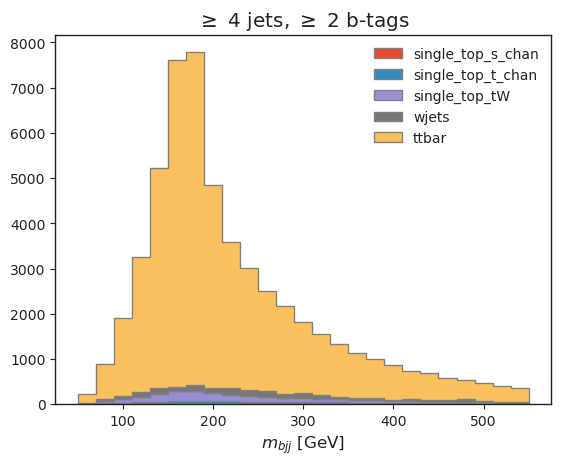

In [10]:
all_histograms["hist_dict"]["4j2b"][:, :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1,edgecolor="grey")
plt.legend(frameon=False)
plt.title("$\geq$ 4 jets, $\geq$ 2 b-tags")
plt.xlabel("$m_{bjj}$ [GeV]");

Our top reconstruction approach ($bjj$ system with largest $p_T$) has worked!

Let's also have a look at some systematic variations:
- b-tagging, which we implemented as jet-kinematic dependent event weights,
- jet energy variations, which vary jet kinematics, resulting in acceptance effects and observable changes.

We are making of [UHI](https://uhi.readthedocs.io/) here to re-bin.

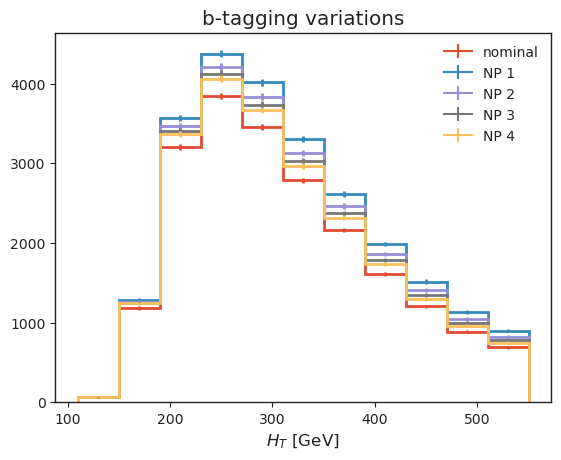

In [11]:
# b-tagging variations
all_histograms["hist_dict"]["4j1b"][120j::hist.rebin(2), "ttbar", "nominal"].plot(label="nominal", linewidth=2)
all_histograms["hist_dict"]["4j1b"][120j::hist.rebin(2), "ttbar", "btag_var_0_up"].plot(label="NP 1", linewidth=2)
all_histograms["hist_dict"]["4j1b"][120j::hist.rebin(2), "ttbar", "btag_var_1_up"].plot(label="NP 2", linewidth=2)
all_histograms["hist_dict"]["4j1b"][120j::hist.rebin(2), "ttbar", "btag_var_2_up"].plot(label="NP 3", linewidth=2)
all_histograms["hist_dict"]["4j1b"][120j::hist.rebin(2), "ttbar", "btag_var_3_up"].plot(label="NP 4", linewidth=2)
plt.legend(frameon=False)
plt.xlabel("$H_T$ [GeV]")
plt.title("b-tagging variations");

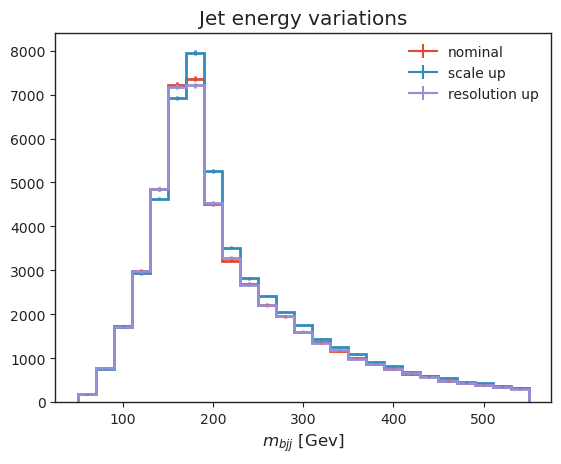

In [12]:
# jet energy scale variations
all_histograms["hist_dict"]["4j2b"][:, "ttbar", "nominal"].plot(label="nominal", linewidth=2)
all_histograms["hist_dict"]["4j2b"][:, "ttbar", "pt_scale_up"].plot(label="scale up", linewidth=2)
all_histograms["hist_dict"]["4j2b"][:, "ttbar", "pt_res_up"].plot(label="resolution up", linewidth=2)
plt.legend(frameon=False)
plt.xlabel("$m_{bjj}$ [Gev]")
plt.title("Jet energy variations");

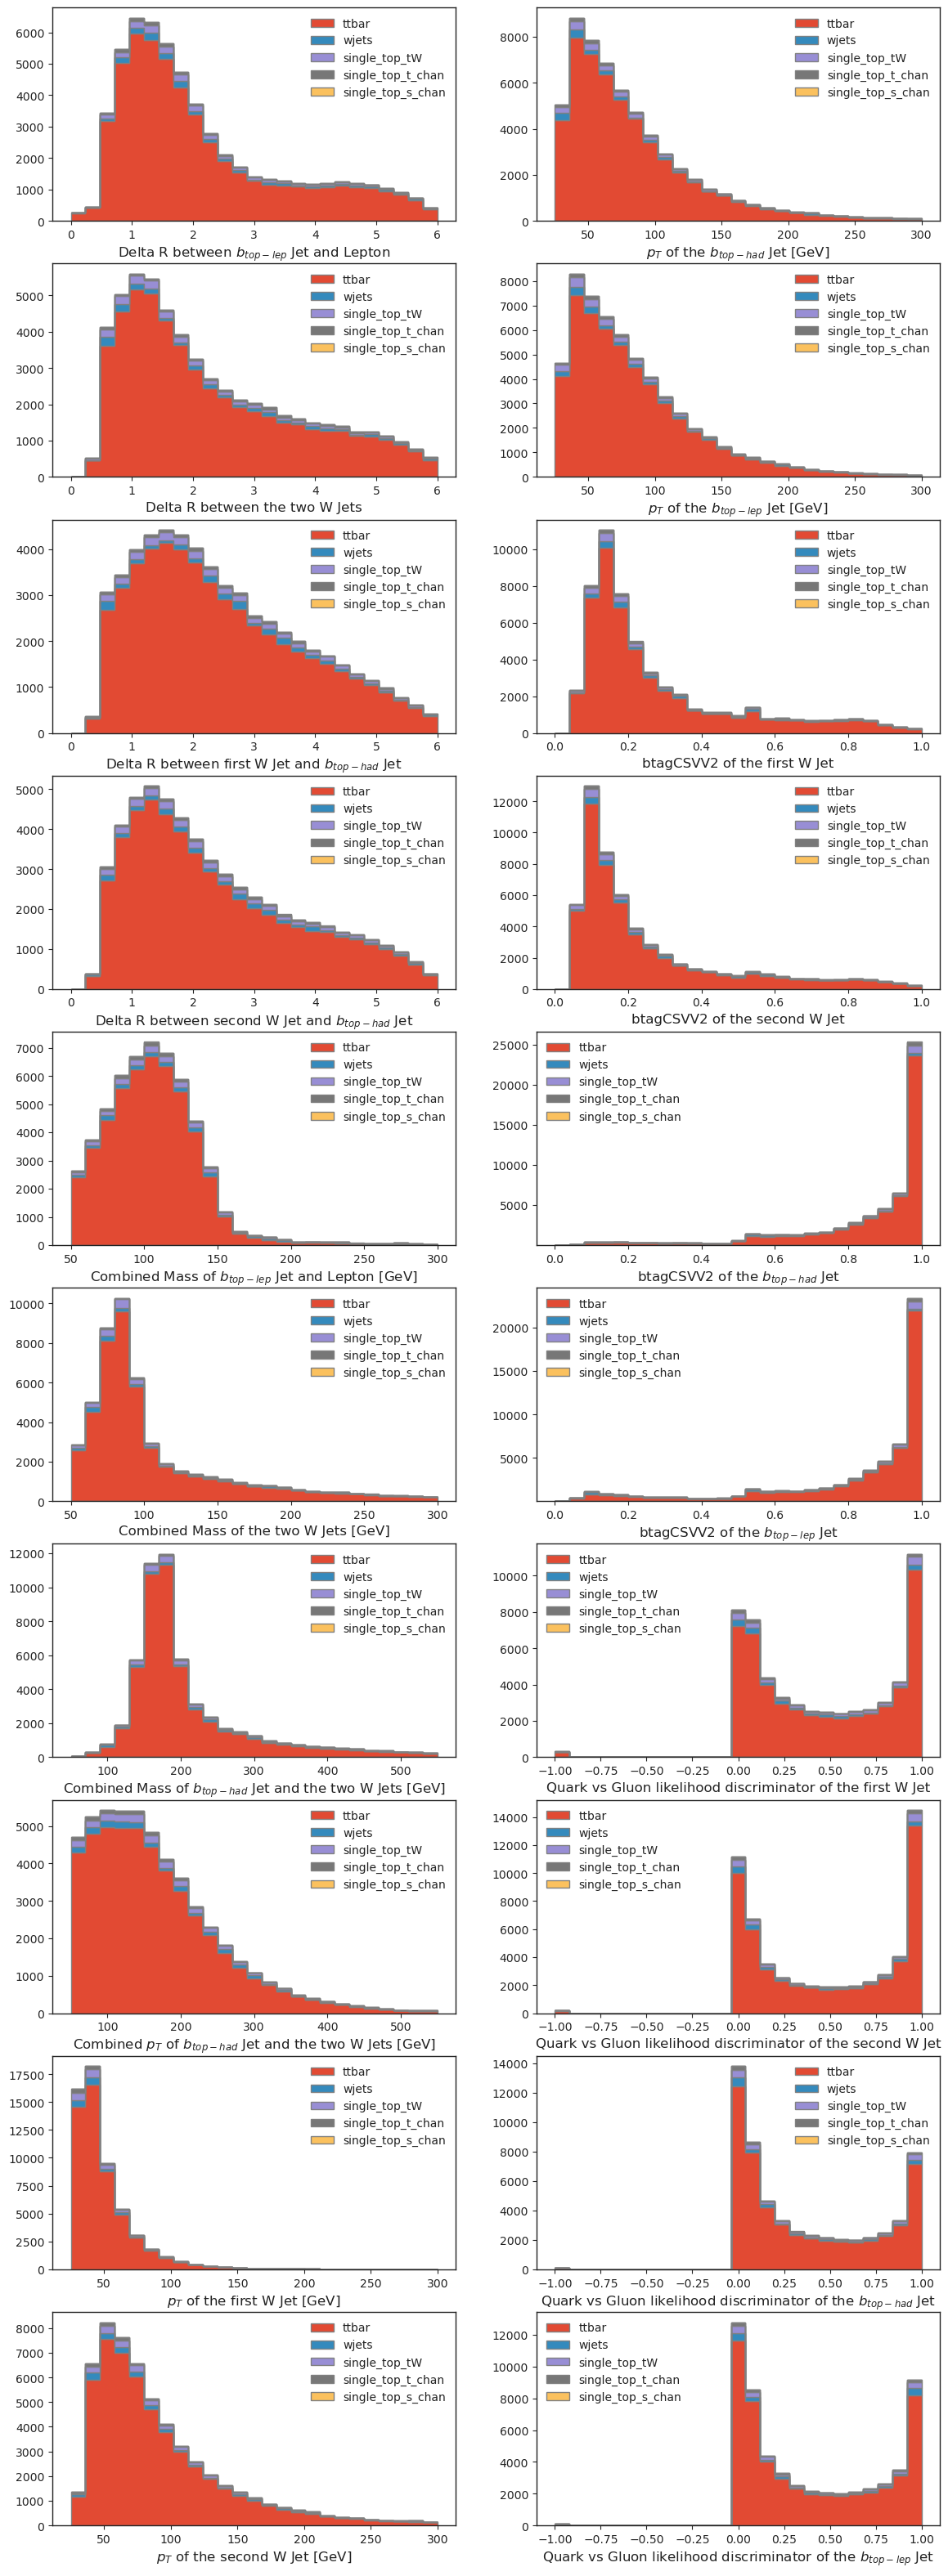

In [13]:
# ML inference variables
if USE_INFERENCE:
    fig, axs = plt.subplots(10,2,figsize=(14,40))
    for i in range(len(utils.config["ml"]["FEATURE_NAMES"])):
        if i<10: 
            column=0
            row=i
        else: 
            column=1
            row=i-10
        all_histograms['ml_hist_dict'][utils.config["ml"]["FEATURE_NAMES"][i]][:, :, "nominal"].stack("process").project("observable").plot(
            stack=True, 
            histtype="fill", 
            linewidth=1, 
            edgecolor="grey", 
            ax=axs[row,column]
        )
        axs[row, column].legend(frameon=False)
    fig.show()

### Save histograms to disk

We'll save everything to disk for subsequent usage.
This also builds pseudo-data by combining events from the various simulation setups we have processed.

In [14]:
utils.file_output.save_histograms(all_histograms['hist_dict'], "histograms.root")

if USE_INFERENCE:
    utils.file_output.save_histograms(all_histograms['ml_hist_dict'], "histograms_ml.root", add_offset=True)

### Statistical inference

We are going to perform a re-binning for the statistical inference.
This is planned to be conveniently provided via cabinetry (see [cabinetry#412](https://github.com/scikit-hep/cabinetry/issues/412), but in the meantime we can achieve this via [template building overrides](https://cabinetry.readthedocs.io/en/latest/advanced.html#overrides-for-template-building).
The implementation is provided in a function in `utils/`.

A statistical model has been defined in `config.yml`, ready to be used with our output.
We will use `cabinetry` to combine all histograms into a `pyhf` workspace and fit the resulting statistical model to the pseudodata we built.

In [15]:
import utils.rebinning  # noqa: E402

cabinetry_config = cabinetry.configuration.load("cabinetry_config.yml")

# rebinning: lower edge 110 GeV, merge bins 2->1
rebinning_router = utils.rebinning.get_cabinetry_rebinning_router(cabinetry_config, rebinning=slice(110j, None, hist.rebin(2)))
cabinetry.templates.build(cabinetry_config, router=rebinning_router)
cabinetry.templates.postprocess(cabinetry_config)  # optional post-processing (e.g. smoothing)
ws = cabinetry.workspace.build(cabinetry_config)
cabinetry.workspace.save(ws, "workspace.json")

We can inspect the workspace with `pyhf`, or use `pyhf` to perform inference.

In [16]:
!pyhf inspect workspace.json | head -n 20

                  Summary       
            ------------------  
               channels  2
                samples  5
             parameters  14
              modifiers  14

               channels  nbins
             ----------  -----
                4j1b CR   11  
                4j2b SR   11  

                samples
             ----------
                 W+jets
  single top, s-channel
  single top, t-channel
                     tW
                  ttbar



Let's try out what we built: the next cell will perform a maximum likelihood fit of our statistical model to the pseudodata we built.

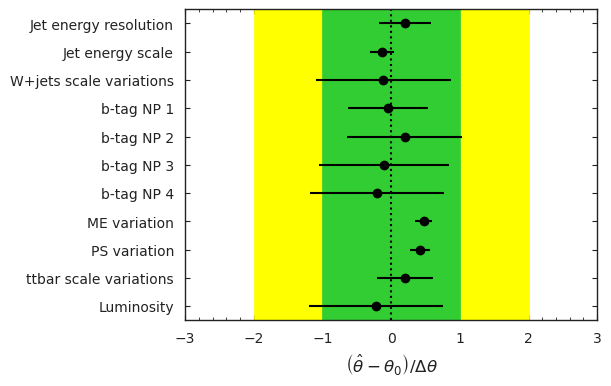

In [17]:
model, data = cabinetry.model_utils.model_and_data(ws)
fit_results = cabinetry.fit.fit(model, data)

cabinetry.visualize.pulls(
    fit_results, exclude="ttbar_norm", close_figure=True, save_figure=False
)

For this pseudodata, what is the resulting ttbar cross-section divided by the Standard Model prediction?

In [18]:
poi_index = model.config.poi_index
print(f"\nfit result for ttbar_norm: {fit_results.bestfit[poi_index]:.3f} +/- {fit_results.uncertainty[poi_index]:.3f}")


fit result for ttbar_norm: 0.956 +/- 0.092


Let's also visualize the model before and after the fit, in both the regions we are using.
The binning here corresponds to the binning used for the fit.

[{'figure': <Figure size 1200x600 with 4 Axes>, 'region': '4j1b CR'},
 {'figure': <Figure size 1200x600 with 4 Axes>, 'region': '4j2b SR'}]

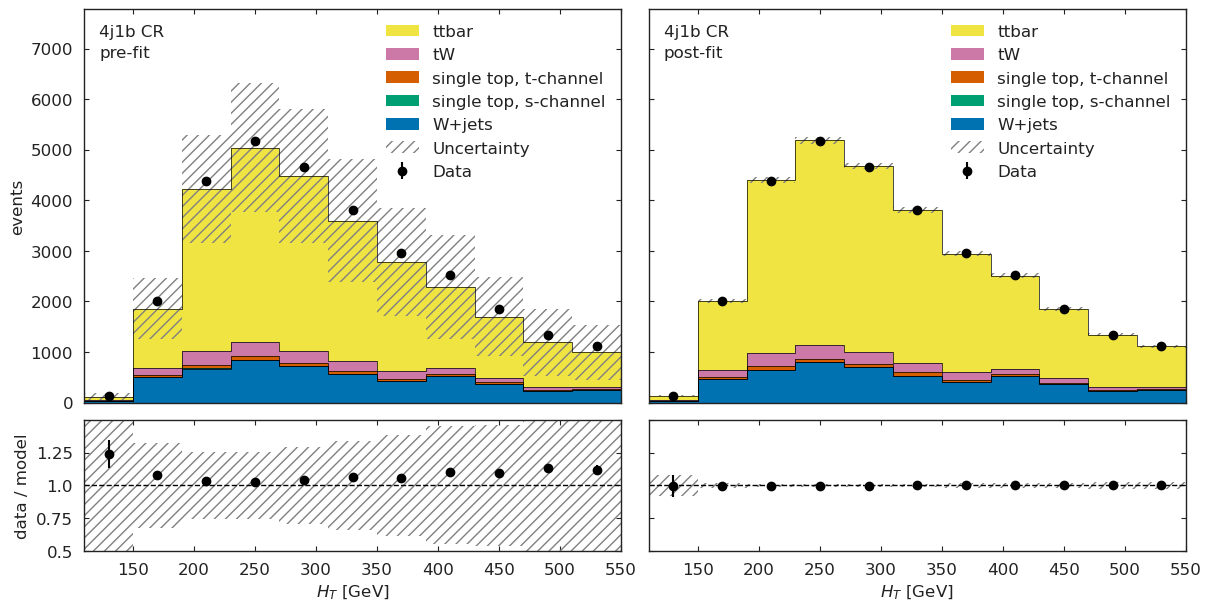

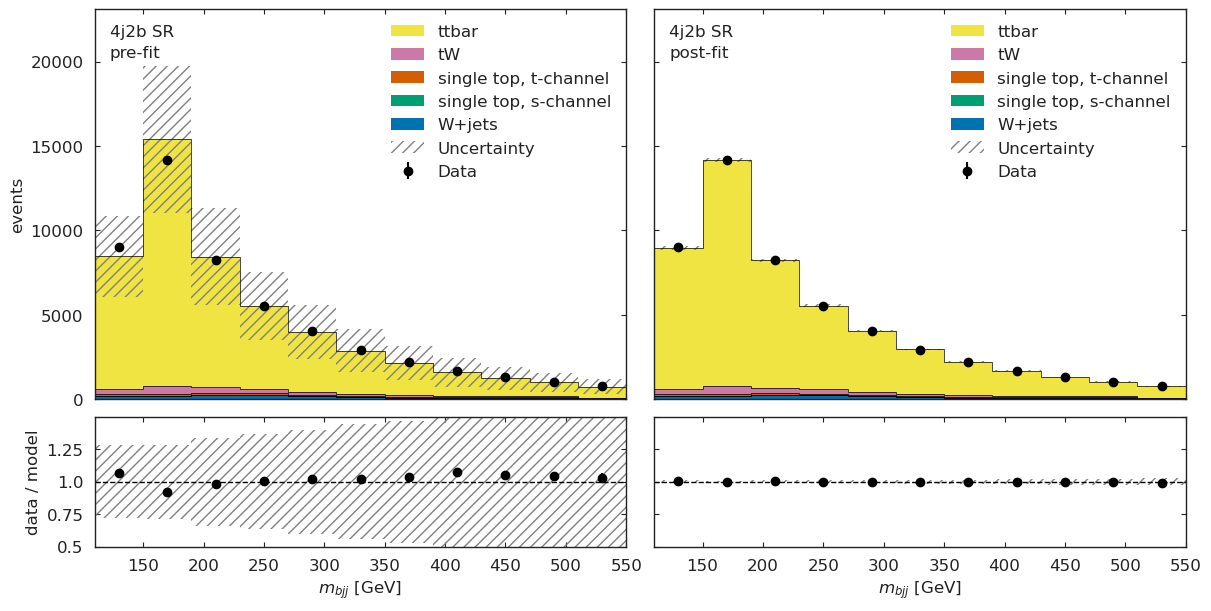

In [19]:
model_prediction = cabinetry.model_utils.prediction(model)
model_prediction_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
figs = cabinetry.visualize.data_mc(model_prediction, data, close_figure=True, config=cabinetry_config)
# below method reimplements this visualization in a grid view
utils.plotting.plot_data_mc(model_prediction, model_prediction_postfit, data, cabinetry_config)

### ML Validation
We can further validate our results by applying the above fit to different ML observables and checking for good agreement.

In [20]:
# load the ml workspace (uses the ml observable instead of previous method)
if USE_INFERENCE:
    config_ml = cabinetry.configuration.load("cabinetry_config_ml.yml")
    cabinetry.templates.collect(config_ml)
    cabinetry.templates.postprocess(config_ml)  # optional post-processing (e.g. smoothing)

    ws_ml = cabinetry.workspace.build(config_ml)
    ws_pruned = pyhf.Workspace(ws_ml).prune(channels=["Feature3", "Feature8", "Feature9",
                                                      "Feature10", "Feature11", "Feature12",
                                                      "Feature13", "Feature14", "Feature15",
                                                      "Feature16", "Feature17", "Feature18",
                                                      "Feature19"])

    cabinetry.workspace.save(ws_pruned, "workspace_ml.json")

In [21]:
if USE_INFERENCE:
    model_ml, data_ml = cabinetry.model_utils.model_and_data(ws_pruned)

We have a channel for each ML observable:

In [22]:
!pyhf inspect workspace_ml.json | head -n 20

                  Summary       
            ------------------  
               channels  7
                samples  5
             parameters  19
              modifiers  19

               channels  nbins
             ----------  -----
               Feature0   25  
               Feature1   25  
               Feature2   25  
               Feature4   25  
               Feature5   25  
               Feature6   25  
               Feature7   25  

                samples
             ----------
                 W+jets


In [23]:
# obtain model prediction before and after fit
if USE_INFERENCE:
    model_prediction_ml = cabinetry.model_utils.prediction(model_ml)
    fit_results_mod = cabinetry.model_utils.match_fit_results(model_ml, fit_results)
    model_prediction_postfit_ml = cabinetry.model_utils.prediction(model_ml, fit_results=fit_results_mod)

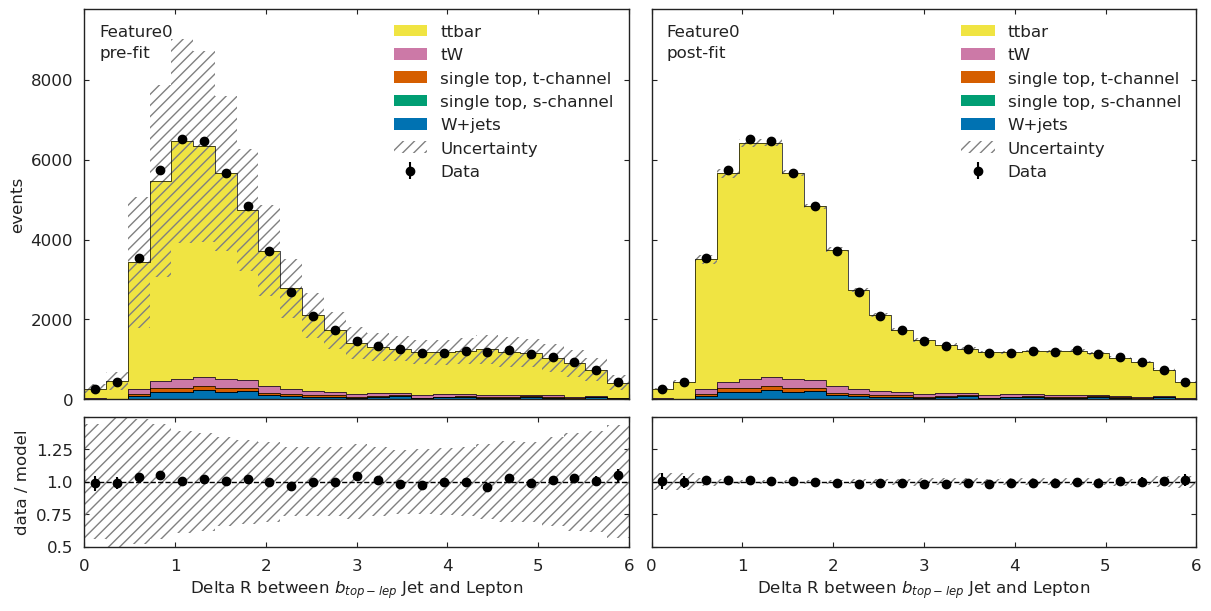

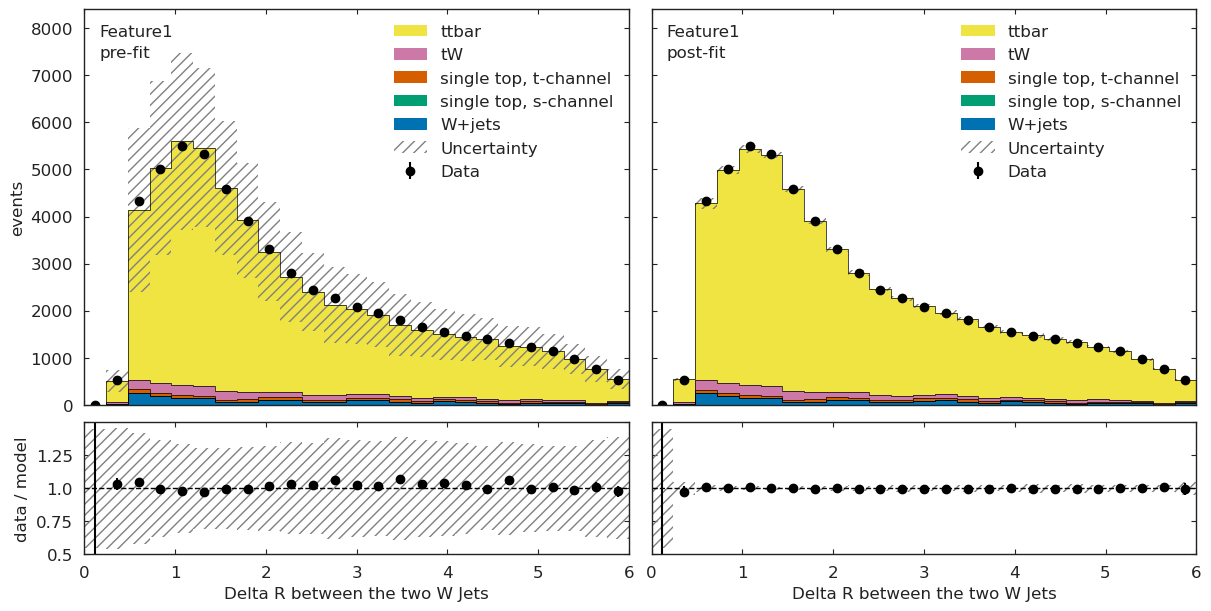

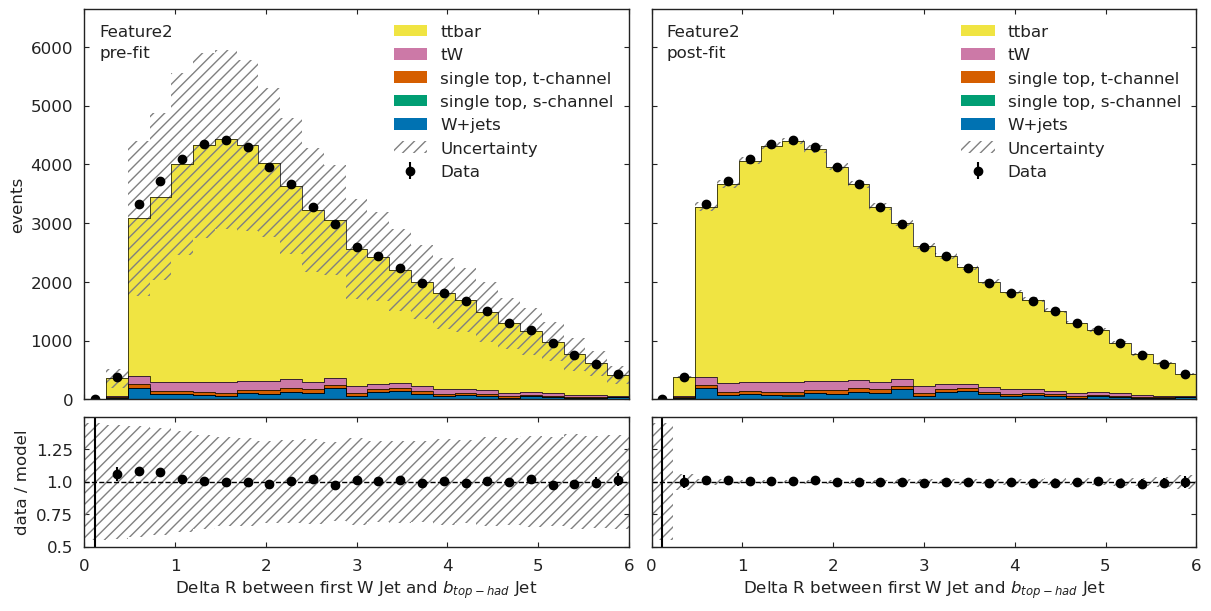

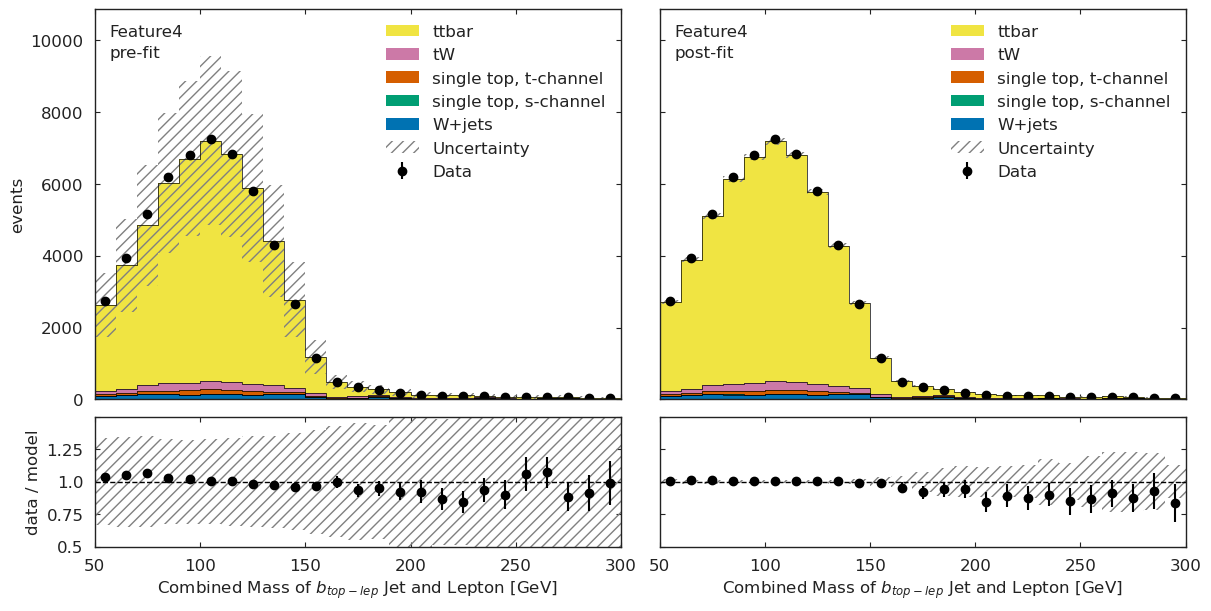

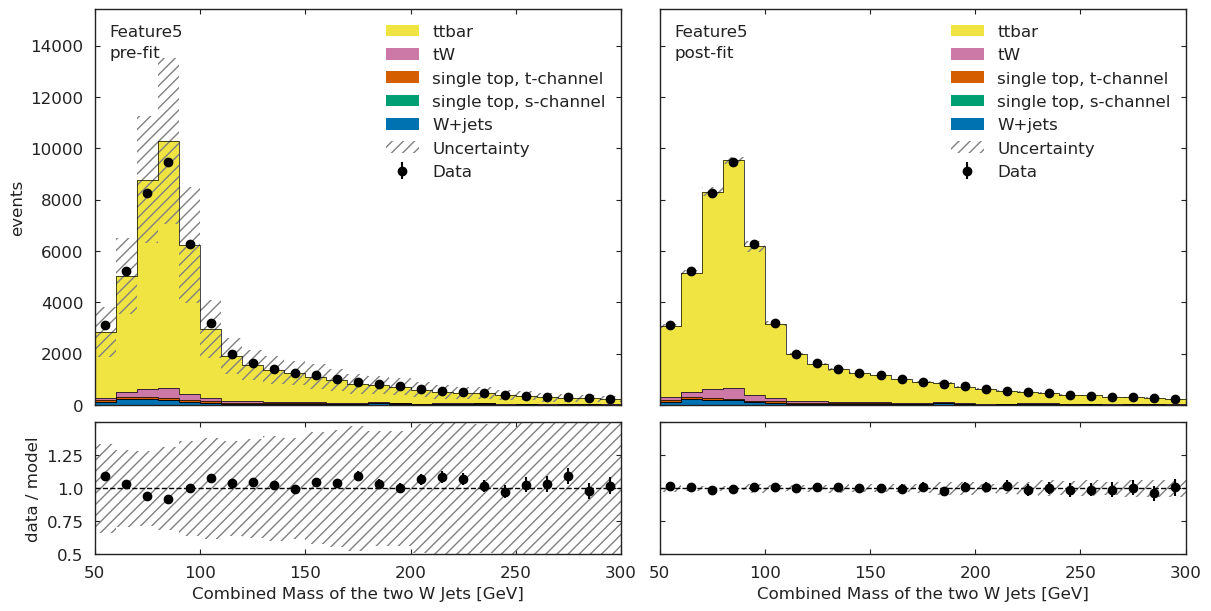

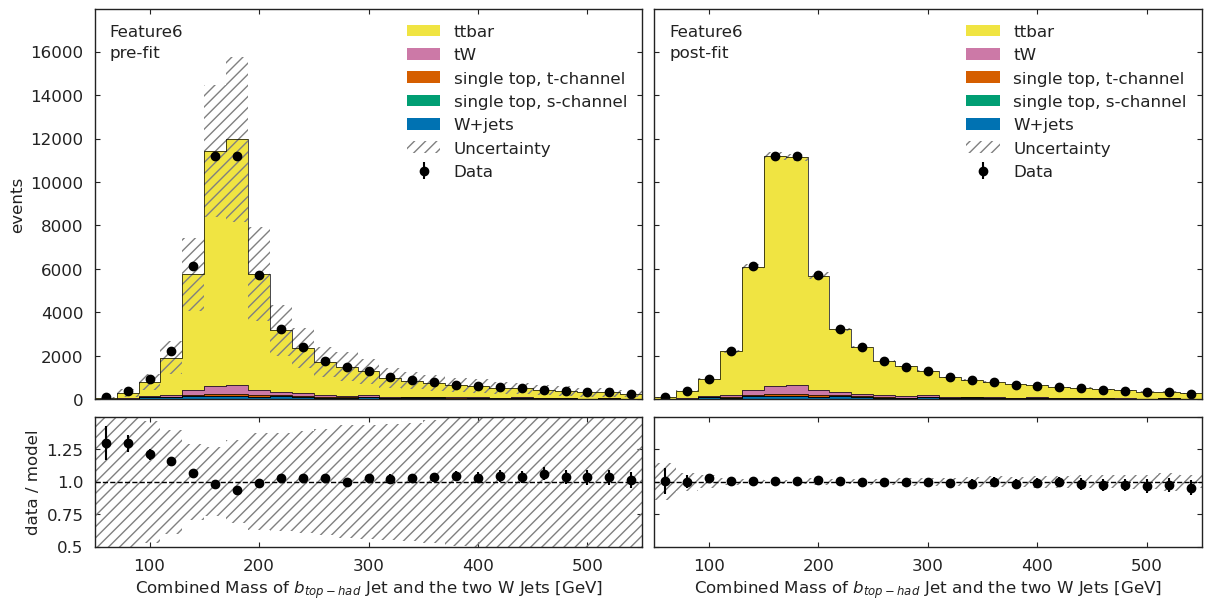

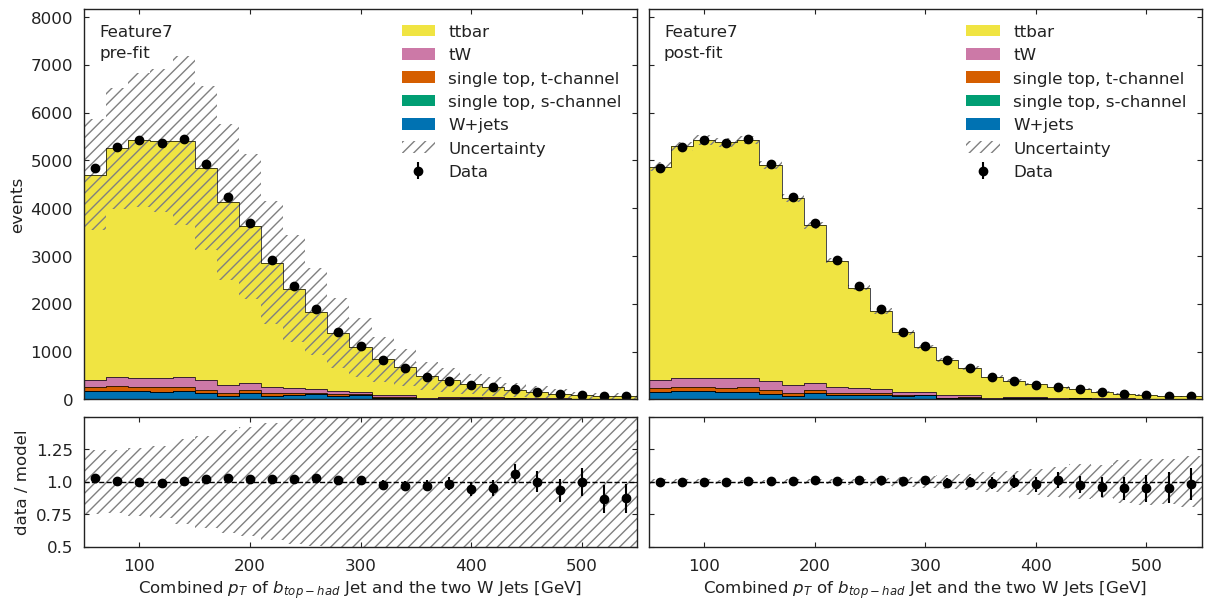

In [24]:
if USE_INFERENCE:
    utils.plotting.plot_data_mc(model_prediction_ml, model_prediction_postfit_ml, data_ml, config_ml)

In [ ]:
if utils.config["preservation"]["HEPData"] is True:
    import utils.hepdata
    #Submission of model prediction
    utils.hepdata.preparing_hep_data_format(model, model_prediction, "hepdata_model", cabinetry_config)
    #Submission of model_ml prediction
    utils.hepdata.preparing_hep_data_format(model_ml, model_prediction_ml,"hepdata_model_ml", config_ml)

### What is next?

Our next goals for this pipeline demonstration are:
- making this analysis even **more feature-complete**,
- **addressing performance bottlenecks** revealed by this demonstrator,
- **collaborating** with you!

Please do not hesitate to get in touch if you would like to join the effort, or are interested in re-implementing (pieces of) the pipeline with different tools!

Our mailing list is analysis-grand-challenge@iris-hep.org, sign up via the [Google group](https://groups.google.com/a/iris-hep.org/g/analysis-grand-challenge).